In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [14]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [15]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [9]:
# load in this fits file
data_fits_fn = '../data/'
# save data in this json file
data_json_fn = '../data/data_w_dith.json'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    
    # Alex's proposed selection criteria
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    
    # Store data as DataFrame, then save as json
    df = pd.DataFrame(selected_d, columns=column_names)
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Configure model, dataset, and training setup

In [10]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)



## Dataset instantiation and get train dataloader

In [12]:
# Construct dataset and select
dataset = OfflineDECamDataset(
    df, 
    specific_years=[2014],
    binning_method='healpix',
    nside=8,
    bin_space='radec',
    specific_months=[12]
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


ValueError: THETA is out of range [0,pi]

## Algorithm and agent setup

In [16]:
# ---------- Set up algorithm ---------- #

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
}

alg = BehaviorCloning(**alg_config)

# ---------- Choose training params ---------- #

fit_config = {
    'num_epochs' : 5, # ie, 5 passes through entire train dataset
    'batch_size': 32,
    # 'learning_start': 
    }


# ---------- Create experiment name and outdir from configs ---------- #

env_name = 'TelescopeEnv-v0'
def create_exp_name(alg, dataset, fit_config, alg_config, env_name=None):
    exp_name = f"{alg.name}"
    if env_name:
        exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

# ---------- Set up agent ---------- #

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [17]:
try:
    # Load if experimente already run
    agent.load(outdir + 'weights.pt')
except:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s')

  0%|                                                                                                                                        | 0/82735 [00:00<?, ?it/s]/home/rachel/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/rachel/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                                                                                                              | 38/82735 [00:00<07:36, 181.06it/s]

Train step 0: Accuracy = 0.000, Loss = 6.6441, Q-val=0.000


  0%|▏                                                                                                                            | 160/82735 [00:00<03:54, 352.27it/s]

Train step 100: Accuracy = 0.094, Loss = 3.7349, Q-val=0.000


  0%|▍                                                                                                                            | 288/82735 [00:00<03:25, 401.97it/s]

Train step 200: Accuracy = 0.219, Loss = 3.2448, Q-val=0.000


  0%|▌                                                                                                                            | 373/82735 [00:01<03:19, 412.85it/s]

Train step 300: Accuracy = 0.281, Loss = 2.4588, Q-val=0.000


  1%|▋                                                                                                                            | 460/82735 [00:01<03:14, 422.74it/s]

Train step 400: Accuracy = 0.406, Loss = 2.7053, Q-val=0.000


  1%|▊                                                                                                                            | 547/82735 [00:01<03:13, 425.60it/s]

Train step 500: Accuracy = 0.406, Loss = 2.2606, Q-val=0.000


  1%|█                                                                                                                            | 678/82735 [00:01<03:10, 430.09it/s]

Train step 600: Accuracy = 0.219, Loss = 1.8794, Q-val=0.000


  1%|█▏                                                                                                                           | 766/82735 [00:01<03:10, 431.18it/s]

Train step 700: Accuracy = 0.188, Loss = 1.8429, Q-val=0.000


  1%|█▎                                                                                                                           | 853/82735 [00:02<03:13, 423.05it/s]

Train step 800: Accuracy = 0.281, Loss = 2.2088, Q-val=0.000


  1%|█▍                                                                                                                           | 984/82735 [00:02<03:10, 429.89it/s]

Train step 900: Accuracy = 0.375, Loss = 2.1106, Q-val=0.000


  1%|█▌                                                                                                                          | 1070/82735 [00:02<03:13, 422.44it/s]

Train step 1000: Accuracy = 0.406, Loss = 2.4712, Q-val=0.000


  1%|█▋                                                                                                                          | 1158/82735 [00:02<03:13, 422.36it/s]

Train step 1100: Accuracy = 0.500, Loss = 2.0431, Q-val=0.000


  2%|█▊                                                                                                                          | 1244/82735 [00:03<03:14, 419.32it/s]

Train step 1200: Accuracy = 0.375, Loss = 1.8943, Q-val=0.000


  2%|██                                                                                                                          | 1369/82735 [00:03<03:25, 395.38it/s]

Train step 1300: Accuracy = 0.406, Loss = 1.7330, Q-val=0.000


  2%|██▏                                                                                                                         | 1452/82735 [00:03<03:22, 401.06it/s]

Train step 1400: Accuracy = 0.469, Loss = 1.7683, Q-val=0.000


  2%|██▎                                                                                                                         | 1583/82735 [00:03<03:12, 420.63it/s]

Train step 1500: Accuracy = 0.531, Loss = 1.5115, Q-val=0.000


  2%|██▌                                                                                                                         | 1671/82735 [00:04<03:09, 426.93it/s]

Train step 1600: Accuracy = 0.375, Loss = 1.6956, Q-val=0.000


  2%|██▋                                                                                                                         | 1759/82735 [00:04<03:08, 430.43it/s]

Train step 1700: Accuracy = 0.531, Loss = 1.5221, Q-val=0.000


  2%|██▊                                                                                                                         | 1845/82735 [00:04<03:15, 413.04it/s]

Train step 1800: Accuracy = 0.469, Loss = 1.5863, Q-val=0.000


  2%|██▉                                                                                                                         | 1969/82735 [00:04<03:19, 404.58it/s]

Train step 1900: Accuracy = 0.250, Loss = 1.6260, Q-val=0.000


  2%|███                                                                                                                         | 2052/82735 [00:05<03:18, 406.57it/s]

Train step 2000: Accuracy = 0.375, Loss = 1.3786, Q-val=0.000


  3%|███▎                                                                                                                        | 2180/82735 [00:05<03:13, 416.85it/s]

Train step 2100: Accuracy = 0.469, Loss = 1.6632, Q-val=0.000


  3%|███▍                                                                                                                        | 2265/82735 [00:05<03:12, 418.22it/s]

Train step 2200: Accuracy = 0.531, Loss = 1.5648, Q-val=0.000


  3%|███▌                                                                                                                        | 2351/82735 [00:05<03:12, 418.16it/s]

Train step 2300: Accuracy = 0.438, Loss = 1.8742, Q-val=0.000


  3%|███▋                                                                                                                        | 2481/82735 [00:06<03:07, 426.98it/s]

Train step 2400: Accuracy = 0.500, Loss = 1.2059, Q-val=0.000


  3%|███▊                                                                                                                        | 2569/82735 [00:06<03:08, 425.71it/s]

Train step 2500: Accuracy = 0.500, Loss = 1.5790, Q-val=0.000


  3%|███▉                                                                                                                        | 2659/82735 [00:06<03:03, 435.34it/s]

Train step 2600: Accuracy = 0.562, Loss = 1.4396, Q-val=0.000


  3%|████                                                                                                                        | 2752/82735 [00:06<02:58, 448.57it/s]

Train step 2700: Accuracy = 0.500, Loss = 1.3839, Q-val=0.000


  3%|████▎                                                                                                                       | 2845/82735 [00:06<02:58, 448.12it/s]

Train step 2800: Accuracy = 0.531, Loss = 1.8488, Q-val=0.000


  4%|████▍                                                                                                                       | 2979/82735 [00:07<03:06, 427.70it/s]

Train step 2900: Accuracy = 0.469, Loss = 1.5972, Q-val=0.000


  4%|████▌                                                                                                                       | 3066/82735 [00:07<03:05, 428.86it/s]

Train step 3000: Accuracy = 0.531, Loss = 1.5507, Q-val=0.000


  4%|████▋                                                                                                                       | 3153/82735 [00:07<03:05, 429.04it/s]

Train step 3100: Accuracy = 0.500, Loss = 2.0194, Q-val=0.000


  4%|████▉                                                                                                                       | 3281/82735 [00:07<03:11, 414.03it/s]

Train step 3200: Accuracy = 0.500, Loss = 1.7935, Q-val=0.000


  4%|█████                                                                                                                       | 3369/82735 [00:08<03:06, 426.23it/s]

Train step 3300: Accuracy = 0.438, Loss = 1.8146, Q-val=0.000


  4%|█████▏                                                                                                                      | 3455/82735 [00:08<03:12, 412.88it/s]

Train step 3400: Accuracy = 0.688, Loss = 1.6558, Q-val=0.000


  4%|█████▍                                                                                                                      | 3587/82735 [00:08<03:04, 428.00it/s]

Train step 3500: Accuracy = 0.500, Loss = 1.6183, Q-val=0.000


  4%|█████▌                                                                                                                      | 3672/82735 [00:08<03:13, 409.25it/s]

Train step 3600: Accuracy = 0.531, Loss = 1.7460, Q-val=0.000


  5%|█████▋                                                                                                                      | 3754/82735 [00:09<03:17, 400.61it/s]

Train step 3700: Accuracy = 0.406, Loss = 1.3448, Q-val=0.000


  5%|█████▊                                                                                                                      | 3875/82735 [00:09<03:18, 397.99it/s]

Train step 3800: Accuracy = 0.688, Loss = 1.0837, Q-val=0.000


  5%|█████▉                                                                                                                      | 3956/82735 [00:09<03:18, 396.47it/s]

Train step 3900: Accuracy = 0.562, Loss = 1.1109, Q-val=0.000


  5%|██████                                                                                                                      | 4076/82735 [00:09<03:22, 389.04it/s]

Train step 4000: Accuracy = 0.438, Loss = 1.4828, Q-val=0.000


  5%|██████▏                                                                                                                     | 4159/82735 [00:10<03:15, 401.73it/s]

Train step 4100: Accuracy = 0.594, Loss = 1.4078, Q-val=0.000


  5%|██████▎                                                                                                                     | 4245/82735 [00:10<03:09, 414.71it/s]

Train step 4200: Accuracy = 0.500, Loss = 1.4471, Q-val=0.000


  5%|██████▌                                                                                                                     | 4376/82735 [00:10<03:04, 424.44it/s]

Train step 4300: Accuracy = 0.438, Loss = 1.3932, Q-val=0.000


  5%|██████▋                                                                                                                     | 4462/82735 [00:10<03:08, 415.65it/s]

Train step 4400: Accuracy = 0.469, Loss = 1.1571, Q-val=0.000


  5%|██████▊                                                                                                                     | 4546/82735 [00:11<03:13, 403.44it/s]

Train step 4500: Accuracy = 0.406, Loss = 1.7708, Q-val=0.000


  6%|███████                                                                                                                     | 4675/82735 [00:11<03:06, 417.54it/s]

Train step 4600: Accuracy = 0.562, Loss = 1.1644, Q-val=0.000


  6%|███████▏                                                                                                                    | 4759/82735 [00:11<03:09, 412.56it/s]

Train step 4700: Accuracy = 0.469, Loss = 1.2693, Q-val=0.000


  6%|███████▎                                                                                                                    | 4842/82735 [00:11<03:12, 405.08it/s]

Train step 4800: Accuracy = 0.594, Loss = 1.1820, Q-val=0.000


  6%|███████▍                                                                                                                    | 4970/82735 [00:12<03:09, 409.33it/s]

Train step 4900: Accuracy = 0.625, Loss = 1.6926, Q-val=0.000


  6%|███████▌                                                                                                                    | 5053/82735 [00:12<03:12, 403.24it/s]

Train step 5000: Accuracy = 0.625, Loss = 1.4088, Q-val=0.000


  6%|███████▊                                                                                                                    | 5180/82735 [00:12<03:07, 412.67it/s]

Train step 5100: Accuracy = 0.531, Loss = 1.2597, Q-val=0.000


  6%|███████▉                                                                                                                    | 5263/82735 [00:12<03:14, 398.89it/s]

Train step 5200: Accuracy = 0.594, Loss = 1.0021, Q-val=0.000


  6%|████████                                                                                                                    | 5346/82735 [00:13<03:10, 406.44it/s]

Train step 5300: Accuracy = 0.438, Loss = 1.3249, Q-val=0.000


  7%|████████▏                                                                                                                   | 5472/82735 [00:13<03:08, 410.02it/s]

Train step 5400: Accuracy = 0.500, Loss = 1.7162, Q-val=0.000


  7%|████████▎                                                                                                                   | 5558/82735 [00:13<03:07, 410.60it/s]

Train step 5500: Accuracy = 0.531, Loss = 1.3977, Q-val=0.000


  7%|████████▌                                                                                                                   | 5686/82735 [00:13<03:05, 415.69it/s]

Train step 5600: Accuracy = 0.594, Loss = 1.1495, Q-val=0.000


  7%|████████▋                                                                                                                   | 5770/82735 [00:14<03:08, 409.28it/s]

Train step 5700: Accuracy = 0.500, Loss = 1.4552, Q-val=0.000


  7%|████████▊                                                                                                                   | 5853/82735 [00:14<03:08, 406.94it/s]

Train step 5800: Accuracy = 0.438, Loss = 1.4304, Q-val=0.000


  7%|████████▉                                                                                                                   | 5978/82735 [00:14<03:07, 410.37it/s]

Train step 5900: Accuracy = 0.594, Loss = 1.6470, Q-val=0.000


  7%|█████████                                                                                                                   | 6062/82735 [00:14<03:06, 410.68it/s]

Train step 6000: Accuracy = 0.562, Loss = 1.2893, Q-val=0.000


  7%|█████████▏                                                                                                                  | 6146/82735 [00:14<03:05, 413.00it/s]

Train step 6100: Accuracy = 0.562, Loss = 2.0425, Q-val=0.000


  8%|█████████▍                                                                                                                  | 6269/82735 [00:15<03:12, 396.82it/s]

Train step 6200: Accuracy = 0.594, Loss = 1.4301, Q-val=0.000


  8%|█████████▌                                                                                                                  | 6349/82735 [00:15<03:15, 390.68it/s]

Train step 6300: Accuracy = 0.375, Loss = 1.0173, Q-val=0.000


  8%|█████████▋                                                                                                                  | 6473/82735 [00:15<03:11, 397.42it/s]

Train step 6400: Accuracy = 0.531, Loss = 1.4928, Q-val=0.000


  8%|█████████▊                                                                                                                  | 6552/82735 [00:16<03:17, 386.42it/s]

Train step 6500: Accuracy = 0.656, Loss = 1.7419, Q-val=0.000


  8%|██████████                                                                                                                  | 6675/82735 [00:16<03:10, 398.68it/s]

Train step 6600: Accuracy = 0.625, Loss = 1.2232, Q-val=0.000


  8%|██████████▏                                                                                                                 | 6756/82735 [00:16<03:09, 399.96it/s]

Train step 6700: Accuracy = 0.500, Loss = 0.9955, Q-val=0.000


  8%|██████████▎                                                                                                                 | 6884/82735 [00:16<03:03, 413.17it/s]

Train step 6800: Accuracy = 0.531, Loss = 1.2890, Q-val=0.000


  8%|██████████▍                                                                                                                 | 6968/82735 [00:17<03:06, 405.52it/s]

Train step 6900: Accuracy = 0.688, Loss = 1.3096, Q-val=0.000


  9%|██████████▌                                                                                                                 | 7049/82735 [00:17<03:10, 397.82it/s]

Train step 7000: Accuracy = 0.688, Loss = 1.5985, Q-val=0.000


  9%|██████████▋                                                                                                                 | 7172/82735 [00:17<03:14, 388.74it/s]

Train step 7100: Accuracy = 0.438, Loss = 1.2093, Q-val=0.000


  9%|██████████▊                                                                                                                 | 7250/82735 [00:17<03:19, 378.51it/s]

Train step 7200: Accuracy = 0.594, Loss = 1.1454, Q-val=0.000


  9%|███████████                                                                                                                 | 7369/82735 [00:18<03:13, 389.07it/s]

Train step 7300: Accuracy = 0.594, Loss = 0.8835, Q-val=0.000


  9%|███████████▏                                                                                                                | 7448/82735 [00:18<03:12, 390.64it/s]

Train step 7400: Accuracy = 0.500, Loss = 1.1464, Q-val=0.000


  9%|███████████▎                                                                                                                | 7568/82735 [00:18<03:12, 390.34it/s]

Train step 7500: Accuracy = 0.562, Loss = 1.7125, Q-val=0.000


  9%|███████████▍                                                                                                                | 7649/82735 [00:18<03:10, 393.60it/s]

Train step 7600: Accuracy = 0.375, Loss = 0.9609, Q-val=0.000


  9%|███████████▋                                                                                                                | 7774/82735 [00:19<03:05, 403.99it/s]

Train step 7700: Accuracy = 0.562, Loss = 1.1467, Q-val=0.000


  9%|███████████▊                                                                                                                | 7857/82735 [00:19<03:03, 408.09it/s]

Train step 7800: Accuracy = 0.594, Loss = 1.4417, Q-val=0.000


 10%|███████████▉                                                                                                                | 7982/82735 [00:19<03:02, 410.71it/s]

Train step 7900: Accuracy = 0.656, Loss = 1.0256, Q-val=0.000


 10%|████████████                                                                                                                | 8066/82735 [00:19<03:03, 407.10it/s]

Train step 8000: Accuracy = 0.531, Loss = 1.2625, Q-val=0.000


 10%|████████████▏                                                                                                               | 8149/82735 [00:20<03:03, 407.42it/s]

Train step 8100: Accuracy = 0.562, Loss = 2.0874, Q-val=0.000


 10%|████████████▍                                                                                                               | 8273/82735 [00:20<03:06, 399.39it/s]

Train step 8200: Accuracy = 0.469, Loss = 1.3776, Q-val=0.000


 10%|████████████▌                                                                                                               | 8354/82735 [00:20<03:09, 392.72it/s]

Train step 8300: Accuracy = 0.656, Loss = 1.5738, Q-val=0.000


 10%|████████████▋                                                                                                               | 8476/82735 [00:20<03:07, 395.09it/s]

Train step 8400: Accuracy = 0.531, Loss = 1.5555, Q-val=0.000


 10%|████████████▊                                                                                                               | 8556/82735 [00:21<03:17, 375.98it/s]

Train step 8500: Accuracy = 0.562, Loss = 1.5523, Q-val=0.000


 10%|█████████████                                                                                                               | 8678/82735 [00:21<03:08, 393.83it/s]

Train step 8600: Accuracy = 0.531, Loss = 1.1992, Q-val=0.000


 11%|█████████████▏                                                                                                              | 8762/82735 [00:21<03:01, 406.91it/s]

Train step 8700: Accuracy = 0.688, Loss = 1.0932, Q-val=0.000


 11%|█████████████▎                                                                                                              | 8845/82735 [00:21<03:01, 407.22it/s]

Train step 8800: Accuracy = 0.469, Loss = 0.9559, Q-val=0.000


 11%|█████████████▍                                                                                                              | 8968/82735 [00:22<03:03, 402.31it/s]

Train step 8900: Accuracy = 0.406, Loss = 1.3492, Q-val=0.000


 11%|█████████████▌                                                                                                              | 9051/82735 [00:22<03:03, 401.41it/s]

Train step 9000: Accuracy = 0.594, Loss = 1.4733, Q-val=0.000


 11%|█████████████▋                                                                                                              | 9172/82735 [00:22<03:08, 390.07it/s]

Train step 9100: Accuracy = 0.656, Loss = 0.8166, Q-val=0.000


 11%|█████████████▊                                                                                                              | 9251/82735 [00:22<03:14, 378.26it/s]

Train step 9200: Accuracy = 0.562, Loss = 1.0585, Q-val=0.000


 11%|██████████████                                                                                                              | 9372/82735 [00:23<03:05, 394.63it/s]

Train step 9300: Accuracy = 0.562, Loss = 1.1565, Q-val=0.000


 11%|██████████████▏                                                                                                             | 9457/82735 [00:23<02:59, 407.53it/s]

Train step 9400: Accuracy = 0.719, Loss = 1.4834, Q-val=0.000


 12%|██████████████▎                                                                                                             | 9582/82735 [00:23<02:57, 412.46it/s]

Train step 9500: Accuracy = 0.469, Loss = 1.0564, Q-val=0.000


 12%|██████████████▍                                                                                                             | 9667/82735 [00:23<02:54, 417.99it/s]

Train step 9600: Accuracy = 0.594, Loss = 1.0778, Q-val=0.000


 12%|██████████████▌                                                                                                             | 9752/82735 [00:24<02:57, 411.05it/s]

Train step 9700: Accuracy = 0.406, Loss = 1.5199, Q-val=0.000


 12%|██████████████▊                                                                                                             | 9876/82735 [00:24<03:00, 404.43it/s]

Train step 9800: Accuracy = 0.750, Loss = 1.3211, Q-val=0.000


 12%|██████████████▉                                                                                                             | 9959/82735 [00:24<02:58, 407.72it/s]

Train step 9900: Accuracy = 0.438, Loss = 1.6588, Q-val=0.000


 12%|██████████████▉                                                                                                            | 10041/82735 [00:24<03:11, 380.22it/s]

Train step 10000: Accuracy = 0.500, Loss = 1.1607, Q-val=0.000


 12%|███████████████                                                                                                            | 10159/82735 [00:25<03:08, 385.69it/s]

Train step 10100: Accuracy = 0.719, Loss = 1.5841, Q-val=0.000


 12%|███████████████▎                                                                                                           | 10280/82735 [00:25<03:02, 398.09it/s]

Train step 10200: Accuracy = 0.375, Loss = 1.5480, Q-val=0.000


 13%|███████████████▍                                                                                                           | 10362/82735 [00:25<03:00, 400.05it/s]

Train step 10300: Accuracy = 0.625, Loss = 1.0329, Q-val=0.000


 13%|███████████████▌                                                                                                           | 10443/82735 [00:25<03:06, 388.10it/s]

Train step 10400: Accuracy = 0.469, Loss = 1.3467, Q-val=0.000


 13%|███████████████▋                                                                                                           | 10565/82735 [00:26<03:09, 380.89it/s]

Train step 10500: Accuracy = 0.469, Loss = 1.2323, Q-val=0.000


 13%|███████████████▊                                                                                                           | 10643/82735 [00:26<03:11, 377.00it/s]

Train step 10600: Accuracy = 0.625, Loss = 1.7931, Q-val=0.000


 13%|████████████████                                                                                                           | 10763/82735 [00:26<03:04, 390.19it/s]

Train step 10700: Accuracy = 0.625, Loss = 1.0701, Q-val=0.000


 13%|████████████████                                                                                                           | 10844/82735 [00:26<03:02, 394.65it/s]

Train step 10800: Accuracy = 0.625, Loss = 0.8338, Q-val=0.000


 13%|████████████████▎                                                                                                          | 10968/82735 [00:27<02:57, 404.47it/s]

Train step 10900: Accuracy = 0.594, Loss = 1.2984, Q-val=0.000


 13%|████████████████▍                                                                                                          | 11050/82735 [00:27<02:59, 400.12it/s]

Train step 11000: Accuracy = 0.625, Loss = 0.9252, Q-val=0.000


 14%|████████████████▌                                                                                                          | 11174/82735 [00:27<02:57, 402.67it/s]

Train step 11100: Accuracy = 0.562, Loss = 1.5259, Q-val=0.000


 14%|████████████████▋                                                                                                          | 11256/82735 [00:27<02:58, 400.78it/s]

Train step 11200: Accuracy = 0.594, Loss = 1.0542, Q-val=0.000


 14%|████████████████▉                                                                                                          | 11381/82735 [00:28<02:53, 410.78it/s]

Train step 11300: Accuracy = 0.500, Loss = 1.0347, Q-val=0.000


 14%|█████████████████                                                                                                          | 11466/82735 [00:28<02:51, 416.30it/s]

Train step 11400: Accuracy = 0.500, Loss = 0.9335, Q-val=0.000


 14%|█████████████████▏                                                                                                         | 11550/82735 [00:28<02:55, 404.69it/s]

Train step 11500: Accuracy = 0.594, Loss = 1.3563, Q-val=0.000


 14%|█████████████████▎                                                                                                         | 11672/82735 [00:28<03:00, 392.62it/s]

Train step 11600: Accuracy = 0.656, Loss = 1.4238, Q-val=0.000


 14%|█████████████████▍                                                                                                         | 11753/82735 [00:29<02:59, 394.64it/s]

Train step 11700: Accuracy = 0.625, Loss = 1.5809, Q-val=0.000


 14%|█████████████████▋                                                                                                         | 11874/82735 [00:29<02:58, 396.16it/s]

Train step 11800: Accuracy = 0.594, Loss = 1.0349, Q-val=0.000


 14%|█████████████████▊                                                                                                         | 11956/82735 [00:29<02:56, 401.65it/s]

Train step 11900: Accuracy = 0.625, Loss = 1.2038, Q-val=0.000


 15%|█████████████████▉                                                                                                         | 12082/82735 [00:29<02:51, 410.80it/s]

Train step 12000: Accuracy = 0.594, Loss = 1.6627, Q-val=0.000


 15%|██████████████████                                                                                                         | 12165/82735 [00:30<02:53, 406.90it/s]

Train step 12100: Accuracy = 0.500, Loss = 1.1475, Q-val=0.000


 15%|██████████████████▏                                                                                                        | 12249/82735 [00:30<02:52, 407.87it/s]

Train step 12200: Accuracy = 0.469, Loss = 1.6656, Q-val=0.000


 15%|██████████████████▍                                                                                                        | 12375/82735 [00:30<02:51, 411.12it/s]

Train step 12300: Accuracy = 0.656, Loss = 0.6989, Q-val=0.000


 15%|██████████████████▌                                                                                                        | 12457/82735 [00:30<02:59, 391.09it/s]

Train step 12400: Accuracy = 0.562, Loss = 1.3563, Q-val=0.000


 15%|██████████████████▋                                                                                                        | 12580/82735 [00:31<02:54, 402.27it/s]

Train step 12500: Accuracy = 0.625, Loss = 1.0129, Q-val=0.000


 15%|██████████████████▊                                                                                                        | 12663/82735 [00:31<02:52, 405.74it/s]

Train step 12600: Accuracy = 0.656, Loss = 1.5367, Q-val=0.000


 15%|██████████████████▉                                                                                                        | 12745/82735 [00:31<02:53, 403.98it/s]

Train step 12700: Accuracy = 0.594, Loss = 0.9989, Q-val=0.000


 16%|███████████████████▏                                                                                                       | 12869/82735 [00:31<02:52, 405.40it/s]

Train step 12800: Accuracy = 0.531, Loss = 1.0937, Q-val=0.000


 16%|███████████████████▎                                                                                                       | 12952/82735 [00:32<02:50, 408.27it/s]

Train step 12900: Accuracy = 0.656, Loss = 1.3098, Q-val=0.000


 16%|███████████████████▍                                                                                                       | 13077/82735 [00:32<02:50, 407.78it/s]

Train step 13000: Accuracy = 0.594, Loss = 1.1715, Q-val=0.000


 16%|███████████████████▌                                                                                                       | 13159/82735 [00:32<02:50, 408.48it/s]

Train step 13100: Accuracy = 0.562, Loss = 1.2273, Q-val=0.000


 16%|███████████████████▋                                                                                                       | 13284/82735 [00:32<02:48, 412.08it/s]

Train step 13200: Accuracy = 0.656, Loss = 1.5550, Q-val=0.000


 16%|███████████████████▉                                                                                                       | 13369/82735 [00:33<02:46, 416.15it/s]

Train step 13300: Accuracy = 0.625, Loss = 2.1478, Q-val=0.000


 16%|████████████████████                                                                                                       | 13454/82735 [00:33<02:45, 419.45it/s]

Train step 13400: Accuracy = 0.562, Loss = 1.5738, Q-val=0.000


 16%|████████████████████▏                                                                                                      | 13581/82735 [00:33<02:46, 414.11it/s]

Train step 13500: Accuracy = 0.781, Loss = 1.2399, Q-val=0.000


 17%|████████████████████▎                                                                                                      | 13664/82735 [00:33<02:49, 407.94it/s]

Train step 13600: Accuracy = 0.656, Loss = 1.0984, Q-val=0.000


 17%|████████████████████▍                                                                                                      | 13747/82735 [00:34<02:48, 408.61it/s]

Train step 13700: Accuracy = 0.656, Loss = 1.3719, Q-val=0.000


 17%|████████████████████▌                                                                                                      | 13872/82735 [00:34<02:46, 413.54it/s]

Train step 13800: Accuracy = 0.625, Loss = 1.5036, Q-val=0.000


 17%|████████████████████▋                                                                                                      | 13957/82735 [00:34<02:46, 413.55it/s]

Train step 13900: Accuracy = 0.438, Loss = 1.3368, Q-val=0.000


 17%|████████████████████▉                                                                                                      | 14084/82735 [00:34<02:46, 412.72it/s]

Train step 14000: Accuracy = 0.656, Loss = 1.7863, Q-val=0.000


 17%|█████████████████████                                                                                                      | 14166/82735 [00:35<02:57, 385.52it/s]

Train step 14100: Accuracy = 0.594, Loss = 1.3351, Q-val=0.000


 17%|█████████████████████▏                                                                                                     | 14245/82735 [00:35<03:00, 380.21it/s]

Train step 14200: Accuracy = 0.688, Loss = 1.2014, Q-val=0.000


 17%|█████████████████████▎                                                                                                     | 14365/82735 [00:35<02:56, 387.18it/s]

Train step 14300: Accuracy = 0.375, Loss = 1.0882, Q-val=0.000


 17%|█████████████████████▍                                                                                                     | 14444/82735 [00:35<03:00, 378.84it/s]

Train step 14400: Accuracy = 0.656, Loss = 0.7927, Q-val=0.000


 18%|█████████████████████▋                                                                                                     | 14564/82735 [00:36<02:55, 387.66it/s]

Train step 14500: Accuracy = 0.750, Loss = 1.0170, Q-val=0.000


 18%|█████████████████████▊                                                                                                     | 14642/82735 [00:36<02:57, 384.62it/s]

Train step 14600: Accuracy = 0.562, Loss = 1.1757, Q-val=0.000


 18%|█████████████████████▉                                                                                                     | 14762/82735 [00:36<02:54, 389.26it/s]

Train step 14700: Accuracy = 0.625, Loss = 1.2446, Q-val=0.000


 18%|██████████████████████                                                                                                     | 14843/82735 [00:36<02:51, 396.33it/s]

Train step 14800: Accuracy = 0.594, Loss = 1.2382, Q-val=0.000


 18%|██████████████████████▏                                                                                                    | 14965/82735 [00:37<02:49, 399.46it/s]

Train step 14900: Accuracy = 0.500, Loss = 1.5187, Q-val=0.000


 18%|██████████████████████▎                                                                                                    | 15048/82735 [00:37<02:47, 403.52it/s]

Train step 15000: Accuracy = 0.406, Loss = 1.2688, Q-val=0.000


 18%|██████████████████████▌                                                                                                    | 15171/82735 [00:37<02:52, 392.26it/s]

Train step 15100: Accuracy = 0.625, Loss = 0.9313, Q-val=0.000


 18%|██████████████████████▋                                                                                                    | 15252/82735 [00:37<02:50, 396.28it/s]

Train step 15200: Accuracy = 0.438, Loss = 1.2662, Q-val=0.000


 19%|██████████████████████▊                                                                                                    | 15379/82735 [00:38<02:43, 411.01it/s]

Train step 15300: Accuracy = 0.625, Loss = 0.9819, Q-val=0.000


 19%|██████████████████████▉                                                                                                    | 15463/82735 [00:38<02:43, 411.01it/s]

Train step 15400: Accuracy = 0.594, Loss = 0.9815, Q-val=0.000


 19%|███████████████████████                                                                                                    | 15547/82735 [00:38<02:43, 410.16it/s]

Train step 15500: Accuracy = 0.562, Loss = 0.9438, Q-val=0.000


 19%|███████████████████████▎                                                                                                   | 15672/82735 [00:38<02:44, 408.63it/s]

Train step 15600: Accuracy = 0.438, Loss = 1.0714, Q-val=0.000


 19%|███████████████████████▍                                                                                                   | 15756/82735 [00:39<02:44, 407.39it/s]

Train step 15700: Accuracy = 0.719, Loss = 1.4437, Q-val=0.000


 19%|███████████████████████▌                                                                                                   | 15882/82735 [00:39<02:41, 413.57it/s]

Train step 15800: Accuracy = 0.562, Loss = 1.1651, Q-val=0.000


 19%|███████████████████████▋                                                                                                   | 15965/82735 [00:39<02:43, 407.80it/s]

Train step 15900: Accuracy = 0.562, Loss = 1.4745, Q-val=0.000


 19%|███████████████████████▊                                                                                                   | 16049/82735 [00:39<02:41, 411.94it/s]

Train step 16000: Accuracy = 0.562, Loss = 1.4176, Q-val=0.000


 20%|████████████████████████                                                                                                   | 16174/82735 [00:40<02:43, 407.55it/s]

Train step 16100: Accuracy = 0.781, Loss = 1.1156, Q-val=0.000


 20%|████████████████████████▏                                                                                                  | 16258/82735 [00:40<02:42, 409.17it/s]

Train step 16200: Accuracy = 0.625, Loss = 0.8838, Q-val=0.000


 20%|████████████████████████▎                                                                                                  | 16384/82735 [00:40<02:42, 408.49it/s]

Train step 16300: Accuracy = 0.625, Loss = 1.4140, Q-val=0.000


 20%|████████████████████████▍                                                                                                  | 16465/82735 [00:40<02:47, 395.10it/s]

Train step 16400: Accuracy = 0.688, Loss = 1.2252, Q-val=0.000


 20%|████████████████████████▌                                                                                                  | 16545/82735 [00:41<02:47, 394.72it/s]

Train step 16500: Accuracy = 0.438, Loss = 1.0826, Q-val=0.000


 20%|████████████████████████▊                                                                                                  | 16663/82735 [00:41<02:56, 375.28it/s]

Train step 16600: Accuracy = 0.594, Loss = 1.1181, Q-val=0.000


 20%|████████████████████████▉                                                                                                  | 16741/82735 [00:41<02:57, 371.69it/s]

Train step 16700: Accuracy = 0.656, Loss = 1.3126, Q-val=0.000


 20%|█████████████████████████                                                                                                  | 16868/82735 [00:41<02:43, 402.63it/s]

Train step 16800: Accuracy = 0.562, Loss = 1.0609, Q-val=0.000


 20%|█████████████████████████▏                                                                                                 | 16950/82735 [00:42<02:44, 401.04it/s]

Train step 16900: Accuracy = 0.750, Loss = 1.0249, Q-val=0.000


 21%|█████████████████████████▍                                                                                                 | 17079/82735 [00:42<02:37, 416.52it/s]

Train step 17000: Accuracy = 0.594, Loss = 1.3017, Q-val=0.000


 21%|█████████████████████████▌                                                                                                 | 17162/82735 [00:42<02:42, 402.90it/s]

Train step 17100: Accuracy = 0.562, Loss = 1.3133, Q-val=0.000


 21%|█████████████████████████▋                                                                                                 | 17246/82735 [00:42<02:40, 406.82it/s]

Train step 17200: Accuracy = 0.469, Loss = 1.0250, Q-val=0.000


 21%|█████████████████████████▊                                                                                                 | 17370/82735 [00:43<02:42, 401.84it/s]

Train step 17300: Accuracy = 0.531, Loss = 1.0790, Q-val=0.000


 21%|█████████████████████████▉                                                                                                 | 17451/82735 [00:43<02:44, 395.67it/s]

Train step 17400: Accuracy = 0.594, Loss = 1.6162, Q-val=0.000


 21%|██████████████████████████                                                                                                 | 17572/82735 [00:43<02:45, 393.53it/s]

Train step 17500: Accuracy = 0.562, Loss = 1.0838, Q-val=0.000


 21%|██████████████████████████▏                                                                                                | 17654/82735 [00:43<02:42, 399.90it/s]

Train step 17600: Accuracy = 0.562, Loss = 1.0464, Q-val=0.000


 21%|██████████████████████████▍                                                                                                | 17779/82735 [00:44<02:41, 402.69it/s]

Train step 17700: Accuracy = 0.531, Loss = 0.9277, Q-val=0.000


 22%|██████████████████████████▌                                                                                                | 17861/82735 [00:44<02:41, 400.66it/s]

Train step 17800: Accuracy = 0.594, Loss = 0.9431, Q-val=0.000


 22%|██████████████████████████▋                                                                                                | 17944/82735 [00:44<02:42, 399.84it/s]

Train step 17900: Accuracy = 0.625, Loss = 1.1351, Q-val=0.000


 22%|██████████████████████████▊                                                                                                | 18071/82735 [00:44<02:36, 413.01it/s]

Train step 18000: Accuracy = 0.500, Loss = 1.3235, Q-val=0.000


 22%|██████████████████████████▉                                                                                                | 18155/82735 [00:45<02:38, 408.67it/s]

Train step 18100: Accuracy = 0.500, Loss = 1.0250, Q-val=0.000


 22%|███████████████████████████▏                                                                                               | 18277/82735 [00:45<02:43, 393.89it/s]

Train step 18200: Accuracy = 0.594, Loss = 1.6153, Q-val=0.000


 22%|███████████████████████████▎                                                                                               | 18358/82735 [00:45<02:44, 390.53it/s]

Train step 18300: Accuracy = 0.438, Loss = 0.8639, Q-val=0.000


 22%|███████████████████████████▍                                                                                               | 18482/82735 [00:45<02:39, 402.41it/s]

Train step 18400: Accuracy = 0.656, Loss = 1.5035, Q-val=0.000


 22%|███████████████████████████▌                                                                                               | 18567/82735 [00:46<02:35, 411.68it/s]

Train step 18500: Accuracy = 0.562, Loss = 1.3129, Q-val=0.000


 23%|███████████████████████████▋                                                                                               | 18652/82735 [00:46<02:36, 410.31it/s]

Train step 18600: Accuracy = 0.719, Loss = 1.1243, Q-val=0.000


 23%|███████████████████████████▉                                                                                               | 18779/82735 [00:46<02:35, 410.84it/s]

Train step 18700: Accuracy = 0.688, Loss = 1.3213, Q-val=0.000


 23%|████████████████████████████                                                                                               | 18863/82735 [00:46<02:35, 411.22it/s]

Train step 18800: Accuracy = 0.531, Loss = 1.3939, Q-val=0.000


 23%|████████████████████████████▏                                                                                              | 18946/82735 [00:47<02:37, 404.85it/s]

Train step 18900: Accuracy = 0.688, Loss = 1.7895, Q-val=0.000


 23%|████████████████████████████▎                                                                                              | 19070/82735 [00:47<02:36, 406.44it/s]

Train step 19000: Accuracy = 0.562, Loss = 0.9394, Q-val=0.000


 23%|████████████████████████████▍                                                                                              | 19155/82735 [00:47<02:33, 414.59it/s]

Train step 19100: Accuracy = 0.562, Loss = 1.0403, Q-val=0.000


 23%|████████████████████████████▋                                                                                              | 19279/82735 [00:47<02:39, 397.55it/s]

Train step 19200: Accuracy = 0.719, Loss = 0.9646, Q-val=0.000


 23%|████████████████████████████▊                                                                                              | 19362/82735 [00:48<02:37, 403.11it/s]

Train step 19300: Accuracy = 0.594, Loss = 0.9642, Q-val=0.000


 24%|████████████████████████████▉                                                                                              | 19443/82735 [00:48<02:40, 395.40it/s]

Train step 19400: Accuracy = 0.406, Loss = 0.9531, Q-val=0.000


 24%|█████████████████████████████                                                                                              | 19567/82735 [00:48<02:35, 406.44it/s]

Train step 19500: Accuracy = 0.500, Loss = 1.3573, Q-val=0.000


 24%|█████████████████████████████▏                                                                                             | 19650/82735 [00:48<02:34, 408.46it/s]

Train step 19600: Accuracy = 0.406, Loss = 1.2962, Q-val=0.000


 24%|█████████████████████████████▍                                                                                             | 19778/82735 [00:49<02:34, 407.04it/s]

Train step 19700: Accuracy = 0.562, Loss = 0.8343, Q-val=0.000


 24%|█████████████████████████████▌                                                                                             | 19860/82735 [00:49<02:36, 401.57it/s]

Train step 19800: Accuracy = 0.781, Loss = 1.1036, Q-val=0.000


 24%|█████████████████████████████▋                                                                                             | 19943/82735 [00:49<02:34, 405.80it/s]

Train step 19900: Accuracy = 0.594, Loss = 1.2969, Q-val=0.000


 24%|█████████████████████████████▊                                                                                             | 20067/82735 [00:49<02:34, 406.28it/s]

Train step 20000: Accuracy = 0.719, Loss = 0.9910, Q-val=0.000


 24%|█████████████████████████████▉                                                                                             | 20151/82735 [00:50<02:32, 410.66it/s]

Train step 20100: Accuracy = 0.438, Loss = 1.1902, Q-val=0.000


 25%|██████████████████████████████▏                                                                                            | 20280/82735 [00:50<02:29, 418.44it/s]

Train step 20200: Accuracy = 0.594, Loss = 1.2528, Q-val=0.000


 25%|██████████████████████████████▎                                                                                            | 20364/82735 [00:50<02:31, 412.08it/s]

Train step 20300: Accuracy = 0.781, Loss = 1.0623, Q-val=0.000


 25%|██████████████████████████████▍                                                                                            | 20448/82735 [00:50<02:31, 411.74it/s]

Train step 20400: Accuracy = 0.594, Loss = 1.2159, Q-val=0.000


 25%|██████████████████████████████▌                                                                                            | 20572/82735 [00:51<02:32, 407.11it/s]

Train step 20500: Accuracy = 0.656, Loss = 1.0827, Q-val=0.000


 25%|██████████████████████████████▋                                                                                            | 20656/82735 [00:51<02:32, 406.68it/s]

Train step 20600: Accuracy = 0.562, Loss = 0.9685, Q-val=0.000


 25%|██████████████████████████████▉                                                                                            | 20780/82735 [00:51<02:34, 400.45it/s]

Train step 20700: Accuracy = 0.812, Loss = 0.9931, Q-val=0.000


 25%|███████████████████████████████                                                                                            | 20863/82735 [00:51<02:32, 405.50it/s]

Train step 20800: Accuracy = 0.656, Loss = 1.0682, Q-val=0.000


 25%|███████████████████████████████▏                                                                                           | 20946/82735 [00:52<02:31, 408.79it/s]

Train step 20900: Accuracy = 0.594, Loss = 1.1780, Q-val=0.000


 25%|███████████████████████████████▎                                                                                           | 21074/82735 [00:52<02:29, 413.63it/s]

Train step 21000: Accuracy = 0.688, Loss = 0.9009, Q-val=0.000


 26%|███████████████████████████████▍                                                                                           | 21158/82735 [00:52<02:28, 413.51it/s]

Train step 21100: Accuracy = 0.656, Loss = 1.1315, Q-val=0.000


 26%|███████████████████████████████▋                                                                                           | 21286/82735 [00:52<02:27, 417.37it/s]

Train step 21200: Accuracy = 0.625, Loss = 1.1204, Q-val=0.000


 26%|███████████████████████████████▊                                                                                           | 21371/82735 [00:53<02:26, 418.38it/s]

Train step 21300: Accuracy = 0.719, Loss = 1.2159, Q-val=0.000


 26%|███████████████████████████████▉                                                                                           | 21457/82735 [00:53<02:26, 419.38it/s]

Train step 21400: Accuracy = 0.531, Loss = 1.2531, Q-val=0.000


 26%|████████████████████████████████                                                                                           | 21583/82735 [00:53<02:28, 411.55it/s]

Train step 21500: Accuracy = 0.625, Loss = 0.9305, Q-val=0.000


 26%|████████████████████████████████▏                                                                                          | 21667/82735 [00:53<02:28, 411.53it/s]

Train step 21600: Accuracy = 0.625, Loss = 0.9609, Q-val=0.000


 26%|████████████████████████████████▎                                                                                          | 21750/82735 [00:53<02:29, 406.75it/s]

Train step 21700: Accuracy = 0.688, Loss = 1.2179, Q-val=0.000


 26%|████████████████████████████████▌                                                                                          | 21874/82735 [00:54<02:30, 403.47it/s]

Train step 21800: Accuracy = 0.688, Loss = 1.4745, Q-val=0.000


 27%|████████████████████████████████▋                                                                                          | 21956/82735 [00:54<02:33, 396.08it/s]

Train step 21900: Accuracy = 0.656, Loss = 1.0209, Q-val=0.000


 27%|████████████████████████████████▊                                                                                          | 22077/82735 [00:54<02:32, 398.08it/s]

Train step 22000: Accuracy = 0.688, Loss = 0.8787, Q-val=0.000


 27%|████████████████████████████████▉                                                                                          | 22158/82735 [00:54<02:31, 398.64it/s]

Train step 22100: Accuracy = 0.719, Loss = 1.1344, Q-val=0.000


 27%|█████████████████████████████████▏                                                                                         | 22284/82735 [00:55<02:26, 412.21it/s]

Train step 22200: Accuracy = 0.594, Loss = 1.1708, Q-val=0.000


 27%|█████████████████████████████████▎                                                                                         | 22368/82735 [00:55<02:27, 410.64it/s]

Train step 22300: Accuracy = 0.562, Loss = 0.7839, Q-val=0.000


 27%|█████████████████████████████████▍                                                                                         | 22451/82735 [00:55<02:32, 396.60it/s]

Train step 22400: Accuracy = 0.406, Loss = 0.9272, Q-val=0.000


 27%|█████████████████████████████████▌                                                                                         | 22573/82735 [00:56<02:32, 395.43it/s]

Train step 22500: Accuracy = 0.562, Loss = 1.0975, Q-val=0.000


 27%|█████████████████████████████████▋                                                                                         | 22653/82735 [00:56<02:32, 393.65it/s]

Train step 22600: Accuracy = 0.625, Loss = 1.1438, Q-val=0.000


 28%|█████████████████████████████████▊                                                                                         | 22775/82735 [00:56<02:30, 397.82it/s]

Train step 22700: Accuracy = 0.562, Loss = 0.9508, Q-val=0.000


 28%|█████████████████████████████████▉                                                                                         | 22856/82735 [00:56<02:30, 398.72it/s]

Train step 22800: Accuracy = 0.594, Loss = 1.0699, Q-val=0.000


 28%|██████████████████████████████████▏                                                                                        | 22976/82735 [00:57<02:32, 392.99it/s]

Train step 22900: Accuracy = 0.594, Loss = 1.3293, Q-val=0.000


 28%|██████████████████████████████████▎                                                                                        | 23058/82735 [00:57<02:29, 399.94it/s]

Train step 23000: Accuracy = 0.469, Loss = 0.8628, Q-val=0.000


 28%|██████████████████████████████████▍                                                                                        | 23143/82735 [00:57<02:25, 409.99it/s]

Train step 23100: Accuracy = 0.531, Loss = 1.1234, Q-val=0.000


 28%|██████████████████████████████████▌                                                                                        | 23266/82735 [00:57<02:31, 391.60it/s]

Train step 23200: Accuracy = 0.688, Loss = 1.2311, Q-val=0.000


 28%|██████████████████████████████████▋                                                                                        | 23345/82735 [00:57<02:32, 389.14it/s]

Train step 23300: Accuracy = 0.469, Loss = 1.1925, Q-val=0.000


 28%|██████████████████████████████████▉                                                                                        | 23463/82735 [00:58<02:34, 383.95it/s]

Train step 23400: Accuracy = 0.750, Loss = 0.9832, Q-val=0.000


 28%|██████████████████████████████████▉                                                                                        | 23541/82735 [00:58<02:34, 383.40it/s]

Train step 23500: Accuracy = 0.625, Loss = 1.1617, Q-val=0.000


 29%|███████████████████████████████████▏                                                                                       | 23664/82735 [00:58<02:27, 399.76it/s]

Train step 23600: Accuracy = 0.531, Loss = 0.8328, Q-val=0.000


 29%|███████████████████████████████████▎                                                                                       | 23745/82735 [00:59<02:31, 388.55it/s]

Train step 23700: Accuracy = 0.781, Loss = 1.3575, Q-val=0.000


 29%|███████████████████████████████████▍                                                                                       | 23868/82735 [00:59<02:26, 401.19it/s]

Train step 23800: Accuracy = 0.500, Loss = 0.8718, Q-val=0.000


 29%|███████████████████████████████████▌                                                                                       | 23951/82735 [00:59<02:28, 396.54it/s]

Train step 23900: Accuracy = 0.500, Loss = 1.0693, Q-val=0.000


 29%|███████████████████████████████████▊                                                                                       | 24075/82735 [00:59<02:30, 390.28it/s]

Train step 24000: Accuracy = 0.594, Loss = 1.3701, Q-val=0.000


 29%|███████████████████████████████████▉                                                                                       | 24158/82735 [01:00<02:25, 401.26it/s]

Train step 24100: Accuracy = 0.500, Loss = 1.2764, Q-val=0.000


 29%|████████████████████████████████████                                                                                       | 24242/82735 [01:00<02:25, 401.57it/s]

Train step 24200: Accuracy = 0.625, Loss = 1.3513, Q-val=0.000


 29%|████████████████████████████████████▏                                                                                      | 24361/82735 [01:00<02:34, 378.01it/s]

Train step 24300: Accuracy = 0.531, Loss = 0.9250, Q-val=0.000


 30%|████████████████████████████████████▎                                                                                      | 24437/82735 [01:00<02:42, 357.98it/s]

Train step 24400: Accuracy = 0.688, Loss = 1.0534, Q-val=0.000


 30%|████████████████████████████████████▌                                                                                      | 24557/82735 [01:01<02:32, 381.40it/s]

Train step 24500: Accuracy = 0.438, Loss = 1.6804, Q-val=0.000


 30%|████████████████████████████████████▋                                                                                      | 24680/82735 [01:01<02:25, 399.85it/s]

Train step 24600: Accuracy = 0.656, Loss = 1.2426, Q-val=0.000


 30%|████████████████████████████████████▊                                                                                      | 24761/82735 [01:01<02:30, 386.48it/s]

Train step 24700: Accuracy = 0.594, Loss = 1.3002, Q-val=0.000


 30%|████████████████████████████████████▉                                                                                      | 24842/82735 [01:01<02:27, 392.59it/s]

Train step 24800: Accuracy = 0.656, Loss = 1.0982, Q-val=0.000


 30%|█████████████████████████████████████                                                                                      | 24965/82735 [01:02<02:29, 386.56it/s]

Train step 24900: Accuracy = 0.656, Loss = 1.3974, Q-val=0.000


 30%|█████████████████████████████████████▏                                                                                     | 25048/82735 [01:02<02:24, 398.92it/s]

Train step 25000: Accuracy = 0.656, Loss = 1.0820, Q-val=0.000


 30%|█████████████████████████████████████▍                                                                                     | 25168/82735 [01:02<02:27, 390.81it/s]

Train step 25100: Accuracy = 0.656, Loss = 1.3280, Q-val=0.000


 31%|█████████████████████████████████████▌                                                                                     | 25248/82735 [01:02<02:26, 391.75it/s]

Train step 25200: Accuracy = 0.469, Loss = 1.0063, Q-val=0.000


 31%|█████████████████████████████████████▋                                                                                     | 25369/82735 [01:03<02:24, 396.99it/s]

Train step 25300: Accuracy = 0.594, Loss = 1.2310, Q-val=0.000


 31%|█████████████████████████████████████▊                                                                                     | 25450/82735 [01:03<02:24, 395.65it/s]

Train step 25400: Accuracy = 0.781, Loss = 0.9900, Q-val=0.000


 31%|██████████████████████████████████████                                                                                     | 25573/82735 [01:03<02:21, 403.17it/s]

Train step 25500: Accuracy = 0.562, Loss = 1.3311, Q-val=0.000


 31%|██████████████████████████████████████▏                                                                                    | 25655/82735 [01:03<02:24, 395.45it/s]

Train step 25600: Accuracy = 0.656, Loss = 1.2938, Q-val=0.000


 31%|██████████████████████████████████████▎                                                                                    | 25776/82735 [01:04<02:22, 399.33it/s]

Train step 25700: Accuracy = 0.594, Loss = 0.9603, Q-val=0.000


 31%|██████████████████████████████████████▍                                                                                    | 25856/82735 [01:04<02:27, 385.74it/s]

Train step 25800: Accuracy = 0.469, Loss = 1.4182, Q-val=0.000


 31%|██████████████████████████████████████▌                                                                                    | 25973/82735 [01:04<02:29, 379.17it/s]

Train step 25900: Accuracy = 0.500, Loss = 0.9135, Q-val=0.000


 31%|██████████████████████████████████████▋                                                                                    | 26051/82735 [01:04<02:28, 381.91it/s]

Train step 26000: Accuracy = 0.656, Loss = 0.9097, Q-val=0.000


 32%|██████████████████████████████████████▉                                                                                    | 26168/82735 [01:05<02:30, 375.60it/s]

Train step 26100: Accuracy = 0.656, Loss = 0.8791, Q-val=0.000


 32%|███████████████████████████████████████                                                                                    | 26242/82735 [01:05<02:41, 350.45it/s]

Train step 26200: Accuracy = 0.469, Loss = 1.4561, Q-val=0.000


 32%|███████████████████████████████████████▏                                                                                   | 26357/82735 [01:05<02:31, 372.23it/s]

Train step 26300: Accuracy = 0.625, Loss = 1.2910, Q-val=0.000


 32%|███████████████████████████████████████▎                                                                                   | 26475/82735 [01:06<02:26, 384.16it/s]

Train step 26400: Accuracy = 0.656, Loss = 0.9496, Q-val=0.000


 32%|███████████████████████████████████████▍                                                                                   | 26556/82735 [01:06<02:22, 393.80it/s]

Train step 26500: Accuracy = 0.656, Loss = 1.4232, Q-val=0.000


 32%|███████████████████████████████████████▌                                                                                   | 26638/82735 [01:06<02:23, 390.81it/s]

Train step 26600: Accuracy = 0.625, Loss = 0.8587, Q-val=0.000


 32%|███████████████████████████████████████▊                                                                                   | 26755/82735 [01:06<02:35, 360.94it/s]

Train step 26700: Accuracy = 0.562, Loss = 1.1435, Q-val=0.000


 32%|███████████████████████████████████████▉                                                                                   | 26866/82735 [01:07<02:36, 358.13it/s]

Train step 26800: Accuracy = 0.625, Loss = 1.1306, Q-val=0.000


 33%|████████████████████████████████████████                                                                                   | 26938/82735 [01:07<02:37, 354.60it/s]

Train step 26900: Accuracy = 0.625, Loss = 1.2979, Q-val=0.000


 33%|████████████████████████████████████████▏                                                                                  | 27049/82735 [01:07<02:35, 358.82it/s]

Train step 27000: Accuracy = 0.531, Loss = 0.8566, Q-val=0.000


 33%|████████████████████████████████████████▍                                                                                  | 27163/82735 [01:07<02:30, 368.87it/s]

Train step 27100: Accuracy = 0.719, Loss = 1.0518, Q-val=0.000


 33%|████████████████████████████████████████▍                                                                                  | 27237/82735 [01:08<02:32, 364.76it/s]

Train step 27200: Accuracy = 0.562, Loss = 1.4888, Q-val=0.000


 33%|████████████████████████████████████████▋                                                                                  | 27352/82735 [01:08<02:28, 371.98it/s]

Train step 27300: Accuracy = 0.688, Loss = 1.4360, Q-val=0.000


 33%|████████████████████████████████████████▊                                                                                  | 27468/82735 [01:08<02:26, 377.99it/s]

Train step 27400: Accuracy = 0.531, Loss = 0.6261, Q-val=0.000


 33%|████████████████████████████████████████▉                                                                                  | 27546/82735 [01:08<02:27, 375.13it/s]

Train step 27500: Accuracy = 0.531, Loss = 0.9828, Q-val=0.000


 33%|█████████████████████████████████████████                                                                                  | 27661/82735 [01:09<02:27, 374.60it/s]

Train step 27600: Accuracy = 0.594, Loss = 1.0025, Q-val=0.000


 34%|█████████████████████████████████████████▎                                                                                 | 27779/82735 [01:09<02:22, 384.54it/s]

Train step 27700: Accuracy = 0.500, Loss = 1.5904, Q-val=0.000


 34%|█████████████████████████████████████████▍                                                                                 | 27856/82735 [01:09<02:25, 377.99it/s]

Train step 27800: Accuracy = 0.469, Loss = 0.8934, Q-val=0.000


 34%|█████████████████████████████████████████▌                                                                                 | 27971/82735 [01:10<02:24, 379.46it/s]

Train step 27900: Accuracy = 0.469, Loss = 0.9098, Q-val=0.000


 34%|█████████████████████████████████████████▋                                                                                 | 28047/82735 [01:10<02:27, 370.91it/s]

Train step 28000: Accuracy = 0.688, Loss = 0.7002, Q-val=0.000


 34%|█████████████████████████████████████████▊                                                                                 | 28162/82735 [01:10<02:25, 373.99it/s]

Train step 28100: Accuracy = 0.656, Loss = 1.1674, Q-val=0.000


 34%|█████████████████████████████████████████▉                                                                                 | 28238/82735 [01:10<02:29, 364.82it/s]

Train step 28200: Accuracy = 0.750, Loss = 1.4611, Q-val=0.000


 34%|██████████████████████████████████████████▏                                                                                | 28350/82735 [01:11<02:29, 364.39it/s]

Train step 28300: Accuracy = 0.625, Loss = 1.0408, Q-val=0.000


 34%|██████████████████████████████████████████▎                                                                                | 28462/82735 [01:11<02:29, 362.24it/s]

Train step 28400: Accuracy = 0.625, Loss = 1.6015, Q-val=0.000


 35%|██████████████████████████████████████████▍                                                                                | 28573/82735 [01:11<02:28, 365.19it/s]

Train step 28500: Accuracy = 0.625, Loss = 1.0871, Q-val=0.000


 35%|██████████████████████████████████████████▌                                                                                | 28650/82735 [01:11<02:24, 374.85it/s]

Train step 28600: Accuracy = 0.500, Loss = 1.0504, Q-val=0.000


 35%|██████████████████████████████████████████▊                                                                                | 28766/82735 [01:12<02:23, 376.57it/s]

Train step 28700: Accuracy = 0.625, Loss = 1.3333, Q-val=0.000


 35%|██████████████████████████████████████████▉                                                                                | 28846/82735 [01:12<02:19, 385.87it/s]

Train step 28800: Accuracy = 0.719, Loss = 1.4707, Q-val=0.000


 35%|███████████████████████████████████████████                                                                                | 28968/82735 [01:12<02:19, 386.29it/s]

Train step 28900: Accuracy = 0.500, Loss = 1.1047, Q-val=0.000


 35%|███████████████████████████████████████████▏                                                                               | 29048/82735 [01:12<02:20, 382.87it/s]

Train step 29000: Accuracy = 0.656, Loss = 0.9700, Q-val=0.000


 35%|███████████████████████████████████████████▎                                                                               | 29167/82735 [01:13<02:19, 383.58it/s]

Train step 29100: Accuracy = 0.500, Loss = 1.0180, Q-val=0.000


 35%|███████████████████████████████████████████▍                                                                               | 29245/82735 [01:13<02:22, 375.15it/s]

Train step 29200: Accuracy = 0.531, Loss = 1.2475, Q-val=0.000


 35%|███████████████████████████████████████████▋                                                                               | 29363/82735 [01:13<02:23, 371.48it/s]

Train step 29300: Accuracy = 0.469, Loss = 1.1855, Q-val=0.000


 36%|███████████████████████████████████████████▊                                                                               | 29441/82735 [01:14<02:21, 376.64it/s]

Train step 29400: Accuracy = 0.656, Loss = 1.2481, Q-val=0.000


 36%|███████████████████████████████████████████▉                                                                               | 29560/82735 [01:14<02:17, 386.91it/s]

Train step 29500: Accuracy = 0.531, Loss = 0.8326, Q-val=0.000


 36%|████████████████████████████████████████████                                                                               | 29680/82735 [01:14<02:15, 390.22it/s]

Train step 29600: Accuracy = 0.594, Loss = 0.7752, Q-val=0.000


 36%|████████████████████████████████████████████▏                                                                              | 29759/82735 [01:14<02:18, 381.89it/s]

Train step 29700: Accuracy = 0.500, Loss = 0.8055, Q-val=0.000


 36%|████████████████████████████████████████████▍                                                                              | 29876/82735 [01:15<02:18, 380.47it/s]

Train step 29800: Accuracy = 0.594, Loss = 1.2989, Q-val=0.000


 36%|████████████████████████████████████████████▌                                                                              | 29956/82735 [01:15<02:16, 386.34it/s]

Train step 29900: Accuracy = 0.656, Loss = 1.1822, Q-val=0.000


 36%|████████████████████████████████████████████▋                                                                              | 30078/82735 [01:15<02:13, 395.13it/s]

Train step 30000: Accuracy = 0.719, Loss = 1.2951, Q-val=0.000


 36%|████████████████████████████████████████████▊                                                                              | 30159/82735 [01:15<02:13, 392.94it/s]

Train step 30100: Accuracy = 0.625, Loss = 1.0448, Q-val=0.000


 37%|████████████████████████████████████████████▉                                                                              | 30242/82735 [01:16<02:11, 400.03it/s]

Train step 30200: Accuracy = 0.625, Loss = 0.7874, Q-val=0.000


 37%|█████████████████████████████████████████████▏                                                                             | 30366/82735 [01:16<02:14, 390.20it/s]

Train step 30300: Accuracy = 0.656, Loss = 1.0426, Q-val=0.000


 37%|█████████████████████████████████████████████▎                                                                             | 30445/82735 [01:16<02:18, 376.78it/s]

Train step 30400: Accuracy = 0.531, Loss = 0.8698, Q-val=0.000


 37%|█████████████████████████████████████████████▍                                                                             | 30566/82735 [01:16<02:14, 388.51it/s]

Train step 30500: Accuracy = 0.531, Loss = 1.1954, Q-val=0.000


 37%|█████████████████████████████████████████████▌                                                                             | 30647/82735 [01:17<02:12, 394.17it/s]

Train step 30600: Accuracy = 0.688, Loss = 0.9355, Q-val=0.000


 37%|█████████████████████████████████████████████▋                                                                             | 30767/82735 [01:17<02:14, 387.09it/s]

Train step 30700: Accuracy = 0.562, Loss = 1.1163, Q-val=0.000


 37%|█████████████████████████████████████████████▊                                                                             | 30848/82735 [01:17<02:11, 395.28it/s]

Train step 30800: Accuracy = 0.656, Loss = 1.4035, Q-val=0.000


 37%|██████████████████████████████████████████████                                                                             | 30973/82735 [01:17<02:08, 403.96it/s]

Train step 30900: Accuracy = 0.625, Loss = 0.8981, Q-val=0.000


 38%|██████████████████████████████████████████████▏                                                                            | 31056/82735 [01:18<02:08, 401.08it/s]

Train step 31000: Accuracy = 0.625, Loss = 1.0264, Q-val=0.000


 38%|██████████████████████████████████████████████▎                                                                            | 31179/82735 [01:18<02:08, 400.37it/s]

Train step 31100: Accuracy = 0.562, Loss = 1.1181, Q-val=0.000


 38%|██████████████████████████████████████████████▍                                                                            | 31262/82735 [01:18<02:08, 399.69it/s]

Train step 31200: Accuracy = 0.750, Loss = 0.9354, Q-val=0.000


 38%|██████████████████████████████████████████████▌                                                                            | 31344/82735 [01:18<02:09, 396.70it/s]

Train step 31300: Accuracy = 0.625, Loss = 1.4156, Q-val=0.000


 38%|██████████████████████████████████████████████▊                                                                            | 31467/82735 [01:19<02:07, 400.72it/s]

Train step 31400: Accuracy = 0.688, Loss = 1.3143, Q-val=0.000


 38%|██████████████████████████████████████████████▉                                                                            | 31551/82735 [01:19<02:07, 402.77it/s]

Train step 31500: Accuracy = 0.594, Loss = 0.9911, Q-val=0.000


 38%|███████████████████████████████████████████████                                                                            | 31672/82735 [01:19<02:09, 393.46it/s]

Train step 31600: Accuracy = 0.688, Loss = 1.0953, Q-val=0.000


 38%|███████████████████████████████████████████████▏                                                                           | 31751/82735 [01:19<02:11, 387.35it/s]

Train step 31700: Accuracy = 0.531, Loss = 1.1433, Q-val=0.000


 39%|███████████████████████████████████████████████▍                                                                           | 31869/82735 [01:20<02:14, 378.26it/s]

Train step 31800: Accuracy = 0.656, Loss = 1.3324, Q-val=0.000


 39%|███████████████████████████████████████████████▍                                                                           | 31946/82735 [01:20<02:15, 376.20it/s]

Train step 31900: Accuracy = 0.531, Loss = 1.2835, Q-val=0.000


 39%|███████████████████████████████████████████████▋                                                                           | 32061/82735 [01:20<02:14, 375.69it/s]

Train step 32000: Accuracy = 0.625, Loss = 0.9496, Q-val=0.000


 39%|███████████████████████████████████████████████▊                                                                           | 32180/82735 [01:21<02:10, 388.35it/s]

Train step 32100: Accuracy = 0.500, Loss = 1.2281, Q-val=0.000


 39%|███████████████████████████████████████████████▉                                                                           | 32263/82735 [01:21<02:06, 399.43it/s]

Train step 32200: Accuracy = 0.656, Loss = 1.2912, Q-val=0.000


 39%|████████████████████████████████████████████████                                                                           | 32345/82735 [01:21<02:05, 402.62it/s]

Train step 32300: Accuracy = 0.594, Loss = 1.2294, Q-val=0.000


 39%|████████████████████████████████████████████████▎                                                                          | 32467/82735 [01:21<02:08, 390.36it/s]

Train step 32400: Accuracy = 0.562, Loss = 0.9169, Q-val=0.000


 39%|████████████████████████████████████████████████▍                                                                          | 32548/82735 [01:22<02:08, 391.83it/s]

Train step 32500: Accuracy = 0.625, Loss = 0.7231, Q-val=0.000


 39%|████████████████████████████████████████████████▌                                                                          | 32669/82735 [01:22<02:07, 391.67it/s]

Train step 32600: Accuracy = 0.688, Loss = 1.2740, Q-val=0.000


 40%|████████████████████████████████████████████████▋                                                                          | 32747/82735 [01:22<02:12, 377.50it/s]

Train step 32700: Accuracy = 0.719, Loss = 0.7278, Q-val=0.000


 40%|████████████████████████████████████████████████▊                                                                          | 32867/82735 [01:22<02:08, 389.16it/s]

Train step 32800: Accuracy = 0.688, Loss = 1.3090, Q-val=0.000


 40%|████████████████████████████████████████████████▉                                                                          | 32947/82735 [01:23<02:06, 394.82it/s]

Train step 32900: Accuracy = 0.562, Loss = 1.9487, Q-val=0.000


 40%|█████████████████████████████████████████████████▏                                                                         | 33071/82735 [01:23<02:04, 397.74it/s]

Train step 33000: Accuracy = 0.750, Loss = 0.9723, Q-val=0.000


 40%|█████████████████████████████████████████████████▎                                                                         | 33150/82735 [01:23<02:09, 382.67it/s]

Train step 33100: Accuracy = 0.688, Loss = 0.8511, Q-val=0.000


 40%|█████████████████████████████████████████████████▍                                                                         | 33266/82735 [01:23<02:13, 369.88it/s]

Train step 33200: Accuracy = 0.750, Loss = 1.5395, Q-val=0.000


 40%|█████████████████████████████████████████████████▌                                                                         | 33342/82735 [01:24<02:14, 366.94it/s]

Train step 33300: Accuracy = 0.562, Loss = 0.8523, Q-val=0.000


 40%|█████████████████████████████████████████████████▊                                                                         | 33464/82735 [01:24<02:06, 389.73it/s]

Train step 33400: Accuracy = 0.719, Loss = 0.8904, Q-val=0.000


 41%|█████████████████████████████████████████████████▊                                                                         | 33545/82735 [01:24<02:05, 392.21it/s]

Train step 33500: Accuracy = 0.500, Loss = 0.8761, Q-val=0.000


 41%|██████████████████████████████████████████████████                                                                         | 33666/82735 [01:24<02:04, 392.93it/s]

Train step 33600: Accuracy = 0.812, Loss = 1.0867, Q-val=0.000


 41%|██████████████████████████████████████████████████▏                                                                        | 33745/82735 [01:25<02:07, 385.39it/s]

Train step 33700: Accuracy = 0.500, Loss = 1.1301, Q-val=0.000


 41%|██████████████████████████████████████████████████▎                                                                        | 33865/82735 [01:25<02:05, 390.35it/s]

Train step 33800: Accuracy = 0.812, Loss = 1.2472, Q-val=0.000


 41%|██████████████████████████████████████████████████▍                                                                        | 33945/82735 [01:25<02:05, 389.77it/s]

Train step 33900: Accuracy = 0.562, Loss = 1.0146, Q-val=0.000


 41%|██████████████████████████████████████████████████▋                                                                        | 34067/82735 [01:25<02:06, 385.99it/s]

Train step 34000: Accuracy = 0.625, Loss = 0.9756, Q-val=0.000


 41%|██████████████████████████████████████████████████▊                                                                        | 34147/82735 [01:26<02:04, 390.58it/s]

Train step 34100: Accuracy = 0.688, Loss = 0.9213, Q-val=0.000


 41%|██████████████████████████████████████████████████▉                                                                        | 34268/82735 [01:26<02:05, 386.70it/s]

Train step 34200: Accuracy = 0.562, Loss = 0.9826, Q-val=0.000


 42%|███████████████████████████████████████████████████                                                                        | 34346/82735 [01:26<02:06, 382.60it/s]

Train step 34300: Accuracy = 0.719, Loss = 1.3359, Q-val=0.000


 42%|███████████████████████████████████████████████████▏                                                                       | 34464/82735 [01:26<02:06, 380.29it/s]

Train step 34400: Accuracy = 0.688, Loss = 1.3478, Q-val=0.000


 42%|███████████████████████████████████████████████████▎                                                                       | 34543/82735 [01:27<02:06, 380.08it/s]

Train step 34500: Accuracy = 0.594, Loss = 1.0504, Q-val=0.000


 42%|███████████████████████████████████████████████████▌                                                                       | 34664/82735 [01:27<02:03, 388.34it/s]

Train step 34600: Accuracy = 0.500, Loss = 1.2282, Q-val=0.000


 42%|███████████████████████████████████████████████████▋                                                                       | 34742/82735 [01:27<02:05, 382.49it/s]

Train step 34700: Accuracy = 0.625, Loss = 0.9042, Q-val=0.000


 42%|███████████████████████████████████████████████████▊                                                                       | 34864/82735 [01:28<02:02, 390.03it/s]

Train step 34800: Accuracy = 0.500, Loss = 0.9678, Q-val=0.000


 42%|███████████████████████████████████████████████████▉                                                                       | 34944/82735 [01:28<02:02, 390.72it/s]

Train step 34900: Accuracy = 0.688, Loss = 0.9065, Q-val=0.000


 42%|████████████████████████████████████████████████████▏                                                                      | 35066/82735 [01:28<02:01, 392.38it/s]

Train step 35000: Accuracy = 0.719, Loss = 0.7680, Q-val=0.000


 42%|████████████████████████████████████████████████████▎                                                                      | 35146/82735 [01:28<02:02, 387.40it/s]

Train step 35100: Accuracy = 0.469, Loss = 1.3324, Q-val=0.000


 43%|████████████████████████████████████████████████████▍                                                                      | 35263/82735 [01:29<02:05, 379.27it/s]

Train step 35200: Accuracy = 0.594, Loss = 0.9670, Q-val=0.000


 43%|████████████████████████████████████████████████████▌                                                                      | 35343/82735 [01:29<02:02, 387.59it/s]

Train step 35300: Accuracy = 0.625, Loss = 0.7535, Q-val=0.000


 43%|████████████████████████████████████████████████████▋                                                                      | 35466/82735 [01:29<01:59, 395.27it/s]

Train step 35400: Accuracy = 0.625, Loss = 0.9679, Q-val=0.000


 43%|████████████████████████████████████████████████████▊                                                                      | 35546/82735 [01:29<02:00, 391.31it/s]

Train step 35500: Accuracy = 0.562, Loss = 1.2812, Q-val=0.000


 43%|█████████████████████████████████████████████████████                                                                      | 35667/82735 [01:30<02:00, 389.84it/s]

Train step 35600: Accuracy = 0.531, Loss = 1.2697, Q-val=0.000


 43%|█████████████████████████████████████████████████████▏                                                                     | 35747/82735 [01:30<02:01, 388.18it/s]

Train step 35700: Accuracy = 0.719, Loss = 1.1159, Q-val=0.000


 43%|█████████████████████████████████████████████████████▎                                                                     | 35867/82735 [01:30<02:01, 387.25it/s]

Train step 35800: Accuracy = 0.656, Loss = 0.9837, Q-val=0.000


 43%|█████████████████████████████████████████████████████▍                                                                     | 35945/82735 [01:30<02:03, 378.59it/s]

Train step 35900: Accuracy = 0.656, Loss = 0.8938, Q-val=0.000


 44%|█████████████████████████████████████████████████████▌                                                                     | 36064/82735 [01:31<02:02, 381.60it/s]

Train step 36000: Accuracy = 0.719, Loss = 0.9916, Q-val=0.000


 44%|█████████████████████████████████████████████████████▋                                                                     | 36143/82735 [01:31<02:00, 387.31it/s]

Train step 36100: Accuracy = 0.531, Loss = 1.2191, Q-val=0.000


 44%|█████████████████████████████████████████████████████▉                                                                     | 36260/82735 [01:31<02:02, 380.63it/s]

Train step 36200: Accuracy = 0.562, Loss = 1.1583, Q-val=0.000


 44%|██████████████████████████████████████████████████████                                                                     | 36341/82735 [01:31<01:59, 388.03it/s]

Train step 36300: Accuracy = 0.438, Loss = 0.9306, Q-val=0.000


 44%|██████████████████████████████████████████████████████▏                                                                    | 36459/82735 [01:32<02:01, 381.23it/s]

Train step 36400: Accuracy = 0.656, Loss = 1.2520, Q-val=0.000


 44%|██████████████████████████████████████████████████████▍                                                                    | 36581/82735 [01:32<01:56, 395.88it/s]

Train step 36500: Accuracy = 0.688, Loss = 1.2390, Q-val=0.000


 44%|██████████████████████████████████████████████████████▌                                                                    | 36662/82735 [01:32<01:55, 397.83it/s]

Train step 36600: Accuracy = 0.625, Loss = 1.0423, Q-val=0.000


 44%|██████████████████████████████████████████████████████▋                                                                    | 36745/82735 [01:32<01:54, 403.34it/s]

Train step 36700: Accuracy = 0.594, Loss = 1.0695, Q-val=0.000


 45%|██████████████████████████████████████████████████████▊                                                                    | 36866/82735 [01:33<01:56, 394.58it/s]

Train step 36800: Accuracy = 0.562, Loss = 0.9273, Q-val=0.000


 45%|██████████████████████████████████████████████████████▉                                                                    | 36945/82735 [01:33<01:59, 383.48it/s]

Train step 36900: Accuracy = 0.594, Loss = 1.1066, Q-val=0.000


 45%|███████████████████████████████████████████████████████                                                                    | 37065/82735 [01:33<01:56, 391.40it/s]

Train step 37000: Accuracy = 0.656, Loss = 0.8314, Q-val=0.000


 45%|███████████████████████████████████████████████████████▏                                                                   | 37146/82735 [01:33<01:55, 393.10it/s]

Train step 37100: Accuracy = 0.531, Loss = 1.1094, Q-val=0.000


 45%|███████████████████████████████████████████████████████▍                                                                   | 37267/82735 [01:34<01:55, 395.27it/s]

Train step 37200: Accuracy = 0.406, Loss = 0.9362, Q-val=0.000


 45%|███████████████████████████████████████████████████████▌                                                                   | 37347/82735 [01:34<01:58, 383.93it/s]

Train step 37300: Accuracy = 0.562, Loss = 0.9186, Q-val=0.000


 45%|███████████████████████████████████████████████████████▋                                                                   | 37466/82735 [01:34<01:56, 389.61it/s]

Train step 37400: Accuracy = 0.625, Loss = 1.2541, Q-val=0.000


 45%|███████████████████████████████████████████████████████▊                                                                   | 37546/82735 [01:34<01:56, 386.80it/s]

Train step 37500: Accuracy = 0.562, Loss = 0.7669, Q-val=0.000


 46%|████████████████████████████████████████████████████████                                                                   | 37669/82735 [01:35<01:52, 399.36it/s]

Train step 37600: Accuracy = 0.781, Loss = 0.9123, Q-val=0.000


 46%|████████████████████████████████████████████████████████                                                                   | 37749/82735 [01:35<01:55, 390.55it/s]

Train step 37700: Accuracy = 0.688, Loss = 1.0741, Q-val=0.000


 46%|████████████████████████████████████████████████████████▎                                                                  | 37869/82735 [01:35<01:56, 383.85it/s]

Train step 37800: Accuracy = 0.469, Loss = 1.0761, Q-val=0.000


 46%|████████████████████████████████████████████████████████▍                                                                  | 37947/82735 [01:35<01:59, 374.77it/s]

Train step 37900: Accuracy = 0.562, Loss = 1.0597, Q-val=0.000


 46%|████████████████████████████████████████████████████████▌                                                                  | 38064/82735 [01:36<01:57, 381.46it/s]

Train step 38000: Accuracy = 0.688, Loss = 1.2430, Q-val=0.000


 46%|████████████████████████████████████████████████████████▋                                                                  | 38142/82735 [01:36<01:58, 377.47it/s]

Train step 38100: Accuracy = 0.656, Loss = 1.2924, Q-val=0.000


 46%|████████████████████████████████████████████████████████▉                                                                  | 38262/82735 [01:36<01:55, 384.99it/s]

Train step 38200: Accuracy = 0.656, Loss = 1.1246, Q-val=0.000


 46%|█████████████████████████████████████████████████████████                                                                  | 38342/82735 [01:37<01:54, 388.97it/s]

Train step 38300: Accuracy = 0.594, Loss = 0.8912, Q-val=0.000


 46%|█████████████████████████████████████████████████████████▏                                                                 | 38465/82735 [01:37<01:50, 399.58it/s]

Train step 38400: Accuracy = 0.500, Loss = 1.1831, Q-val=0.000


 47%|█████████████████████████████████████████████████████████▎                                                                 | 38545/82735 [01:37<01:51, 396.21it/s]

Train step 38500: Accuracy = 0.562, Loss = 1.2370, Q-val=0.000


 47%|█████████████████████████████████████████████████████████▍                                                                 | 38668/82735 [01:37<01:49, 401.64it/s]

Train step 38600: Accuracy = 0.562, Loss = 1.2584, Q-val=0.000


 47%|█████████████████████████████████████████████████████████▌                                                                 | 38749/82735 [01:38<01:51, 394.56it/s]

Train step 38700: Accuracy = 0.562, Loss = 1.0730, Q-val=0.000


 47%|█████████████████████████████████████████████████████████▊                                                                 | 38871/82735 [01:38<01:50, 398.28it/s]

Train step 38800: Accuracy = 0.750, Loss = 1.2695, Q-val=0.000


 47%|█████████████████████████████████████████████████████████▉                                                                 | 38953/82735 [01:38<01:48, 403.80it/s]

Train step 38900: Accuracy = 0.719, Loss = 1.2003, Q-val=0.000


 47%|██████████████████████████████████████████████████████████                                                                 | 39076/82735 [01:38<01:49, 399.64it/s]

Train step 39000: Accuracy = 0.625, Loss = 0.8760, Q-val=0.000


 47%|██████████████████████████████████████████████████████████▏                                                                | 39156/82735 [01:39<01:51, 389.45it/s]

Train step 39100: Accuracy = 0.688, Loss = 1.0550, Q-val=0.000


 47%|██████████████████████████████████████████████████████████▍                                                                | 39275/82735 [01:39<01:50, 392.35it/s]

Train step 39200: Accuracy = 0.469, Loss = 0.7553, Q-val=0.000


 48%|██████████████████████████████████████████████████████████▌                                                                | 39354/82735 [01:39<01:53, 383.54it/s]

Train step 39300: Accuracy = 0.531, Loss = 1.0666, Q-val=0.000


 48%|██████████████████████████████████████████████████████████▋                                                                | 39476/82735 [01:39<01:49, 396.31it/s]

Train step 39400: Accuracy = 0.750, Loss = 0.8262, Q-val=0.000


 48%|██████████████████████████████████████████████████████████▊                                                                | 39558/82735 [01:40<01:47, 401.53it/s]

Train step 39500: Accuracy = 0.562, Loss = 0.8719, Q-val=0.000


 48%|██████████████████████████████████████████████████████████▉                                                                | 39684/82735 [01:40<01:45, 409.92it/s]

Train step 39600: Accuracy = 0.594, Loss = 1.0240, Q-val=0.000


 48%|███████████████████████████████████████████████████████████                                                                | 39765/82735 [01:40<01:50, 387.78it/s]

Train step 39700: Accuracy = 0.781, Loss = 1.5839, Q-val=0.000


 48%|███████████████████████████████████████████████████████████▏                                                               | 39843/82735 [01:40<01:52, 381.62it/s]

Train step 39800: Accuracy = 0.750, Loss = 1.1449, Q-val=0.000


 48%|███████████████████████████████████████████████████████████▍                                                               | 39963/82735 [01:41<01:49, 391.65it/s]

Train step 39900: Accuracy = 0.531, Loss = 0.8244, Q-val=0.000


 48%|███████████████████████████████████████████████████████████▌                                                               | 40043/82735 [01:41<01:49, 391.12it/s]

Train step 40000: Accuracy = 0.625, Loss = 1.2369, Q-val=0.000


 49%|███████████████████████████████████████████████████████████▋                                                               | 40164/82735 [01:41<01:47, 394.72it/s]

Train step 40100: Accuracy = 0.500, Loss = 1.1036, Q-val=0.000


 49%|███████████████████████████████████████████████████████████▊                                                               | 40246/82735 [01:41<01:46, 398.89it/s]

Train step 40200: Accuracy = 0.656, Loss = 0.8676, Q-val=0.000


 49%|████████████████████████████████████████████████████████████                                                               | 40369/82735 [01:42<01:47, 394.71it/s]

Train step 40300: Accuracy = 0.656, Loss = 0.9747, Q-val=0.000


 49%|████████████████████████████████████████████████████████████▏                                                              | 40451/82735 [01:42<01:45, 399.72it/s]

Train step 40400: Accuracy = 0.500, Loss = 1.2353, Q-val=0.000


 49%|████████████████████████████████████████████████████████████▎                                                              | 40575/82735 [01:42<01:44, 402.84it/s]

Train step 40500: Accuracy = 0.625, Loss = 0.8605, Q-val=0.000


 49%|████████████████████████████████████████████████████████████▍                                                              | 40656/82735 [01:42<01:48, 386.63it/s]

Train step 40600: Accuracy = 0.594, Loss = 1.2691, Q-val=0.000


 49%|████████████████████████████████████████████████████████████▌                                                              | 40776/82735 [01:43<01:47, 389.24it/s]

Train step 40700: Accuracy = 0.688, Loss = 1.0948, Q-val=0.000


 49%|████████████████████████████████████████████████████████████▋                                                              | 40854/82735 [01:43<01:47, 387.82it/s]

Train step 40800: Accuracy = 0.594, Loss = 1.1130, Q-val=0.000


 50%|████████████████████████████████████████████████████████████▉                                                              | 40971/82735 [01:43<01:51, 373.33it/s]

Train step 40900: Accuracy = 0.688, Loss = 1.1799, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████                                                              | 41049/82735 [01:43<01:50, 375.87it/s]

Train step 41000: Accuracy = 0.625, Loss = 0.9467, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████▏                                                             | 41167/82735 [01:44<01:47, 387.31it/s]

Train step 41100: Accuracy = 0.719, Loss = 0.9346, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████▎                                                             | 41246/82735 [01:44<01:46, 389.63it/s]

Train step 41200: Accuracy = 0.625, Loss = 0.9205, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████▌                                                             | 41369/82735 [01:44<01:44, 397.45it/s]

Train step 41300: Accuracy = 0.531, Loss = 1.1365, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████▌                                                             | 41450/82735 [01:44<01:44, 394.92it/s]

Train step 41400: Accuracy = 0.625, Loss = 1.5267, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████▊                                                             | 41572/82735 [01:45<01:43, 397.57it/s]

Train step 41500: Accuracy = 0.562, Loss = 0.9217, Q-val=0.000


 50%|█████████████████████████████████████████████████████████████▉                                                             | 41652/82735 [01:45<01:43, 395.89it/s]

Train step 41600: Accuracy = 0.469, Loss = 1.2733, Q-val=0.000


 50%|██████████████████████████████████████████████████████████████                                                             | 41772/82735 [01:45<01:45, 390.04it/s]

Train step 41700: Accuracy = 0.656, Loss = 0.7388, Q-val=0.000


 51%|██████████████████████████████████████████████████████████████▏                                                            | 41850/82735 [01:45<01:48, 375.80it/s]

Train step 41800: Accuracy = 0.625, Loss = 1.3022, Q-val=0.000


 51%|██████████████████████████████████████████████████████████████▍                                                            | 41964/82735 [01:46<01:49, 373.87it/s]

Train step 41900: Accuracy = 0.531, Loss = 1.5348, Q-val=0.000


 51%|██████████████████████████████████████████████████████████████▌                                                            | 42041/82735 [01:46<01:48, 375.03it/s]

Train step 42000: Accuracy = 0.594, Loss = 0.6926, Q-val=0.000


 51%|██████████████████████████████████████████████████████████████▋                                                            | 42159/82735 [01:46<01:48, 374.92it/s]

Train step 42100: Accuracy = 0.719, Loss = 1.0507, Q-val=0.000


 51%|██████████████████████████████████████████████████████████████▊                                                            | 42275/82735 [01:47<01:46, 380.82it/s]

Train step 42200: Accuracy = 0.750, Loss = 0.8167, Q-val=0.000


 51%|██████████████████████████████████████████████████████████████▉                                                            | 42357/82735 [01:47<01:42, 392.13it/s]

Train step 42300: Accuracy = 0.625, Loss = 1.0290, Q-val=0.000


 51%|███████████████████████████████████████████████████████████████▏                                                           | 42476/82735 [01:47<01:43, 389.60it/s]

Train step 42400: Accuracy = 0.688, Loss = 1.4689, Q-val=0.000


 51%|███████████████████████████████████████████████████████████████▎                                                           | 42554/82735 [01:47<01:44, 385.43it/s]

Train step 42500: Accuracy = 0.812, Loss = 1.1560, Q-val=0.000


 52%|███████████████████████████████████████████████████████████████▍                                                           | 42675/82735 [01:48<01:42, 390.39it/s]

Train step 42600: Accuracy = 0.500, Loss = 0.8796, Q-val=0.000


 52%|███████████████████████████████████████████████████████████████▌                                                           | 42756/82735 [01:48<01:41, 392.44it/s]

Train step 42700: Accuracy = 0.750, Loss = 1.1466, Q-val=0.000


 52%|███████████████████████████████████████████████████████████████▋                                                           | 42877/82735 [01:48<01:40, 398.46it/s]

Train step 42800: Accuracy = 0.562, Loss = 1.5792, Q-val=0.000


 52%|███████████████████████████████████████████████████████████████▊                                                           | 42960/82735 [01:48<01:38, 404.93it/s]

Train step 42900: Accuracy = 0.719, Loss = 1.3719, Q-val=0.000


 52%|███████████████████████████████████████████████████████████████▉                                                           | 43041/82735 [01:49<01:48, 366.08it/s]

Train step 43000: Accuracy = 0.531, Loss = 1.2310, Q-val=0.000


 52%|████████████████████████████████████████████████████████████████▏                                                          | 43156/82735 [01:49<01:45, 374.12it/s]

Train step 43100: Accuracy = 0.625, Loss = 1.3339, Q-val=0.000


 52%|████████████████████████████████████████████████████████████████▎                                                          | 43277/82735 [01:49<01:41, 388.47it/s]

Train step 43200: Accuracy = 0.625, Loss = 0.8488, Q-val=0.000


 52%|████████████████████████████████████████████████████████████████▍                                                          | 43355/82735 [01:49<01:41, 387.02it/s]

Train step 43300: Accuracy = 0.656, Loss = 1.0975, Q-val=0.000


 53%|████████████████████████████████████████████████████████████████▋                                                          | 43472/82735 [01:50<01:44, 377.34it/s]

Train step 43400: Accuracy = 0.562, Loss = 1.1146, Q-val=0.000


 53%|████████████████████████████████████████████████████████████████▋                                                          | 43548/82735 [01:50<01:45, 372.81it/s]

Train step 43500: Accuracy = 0.562, Loss = 0.9103, Q-val=0.000


 53%|████████████████████████████████████████████████████████████████▉                                                          | 43666/82735 [01:50<01:40, 386.92it/s]

Train step 43600: Accuracy = 0.688, Loss = 0.9068, Q-val=0.000


 53%|█████████████████████████████████████████████████████████████████                                                          | 43745/82735 [01:50<01:41, 384.34it/s]

Train step 43700: Accuracy = 0.750, Loss = 0.9906, Q-val=0.000


 53%|█████████████████████████████████████████████████████████████████▏                                                         | 43865/82735 [01:51<01:40, 385.40it/s]

Train step 43800: Accuracy = 0.500, Loss = 0.7798, Q-val=0.000


 53%|█████████████████████████████████████████████████████████████████▎                                                         | 43942/82735 [01:51<01:42, 378.31it/s]

Train step 43900: Accuracy = 0.438, Loss = 0.8363, Q-val=0.000


 53%|█████████████████████████████████████████████████████████████████▍                                                         | 44056/82735 [01:51<01:44, 371.79it/s]

Train step 44000: Accuracy = 0.656, Loss = 0.8684, Q-val=0.000


 53%|█████████████████████████████████████████████████████████████████▋                                                         | 44176/82735 [01:52<01:39, 387.24it/s]

Train step 44100: Accuracy = 0.688, Loss = 0.7978, Q-val=0.000


 53%|█████████████████████████████████████████████████████████████████▊                                                         | 44254/82735 [01:52<01:40, 382.63it/s]

Train step 44200: Accuracy = 0.469, Loss = 0.6728, Q-val=0.000


 54%|█████████████████████████████████████████████████████████████████▉                                                         | 44373/82735 [01:52<01:38, 388.41it/s]

Train step 44300: Accuracy = 0.594, Loss = 1.4105, Q-val=0.000


 54%|██████████████████████████████████████████████████████████████████                                                         | 44454/82735 [01:52<01:36, 397.14it/s]

Train step 44400: Accuracy = 0.562, Loss = 1.0132, Q-val=0.000


 54%|██████████████████████████████████████████████████████████████████▎                                                        | 44576/82735 [01:53<01:35, 400.86it/s]

Train step 44500: Accuracy = 0.469, Loss = 1.2443, Q-val=0.000


 54%|██████████████████████████████████████████████████████████████████▍                                                        | 44659/82735 [01:53<01:34, 402.70it/s]

Train step 44600: Accuracy = 0.562, Loss = 0.8630, Q-val=0.000


 54%|██████████████████████████████████████████████████████████████████▌                                                        | 44742/82735 [01:53<01:33, 404.39it/s]

Train step 44700: Accuracy = 0.562, Loss = 1.0076, Q-val=0.000


 54%|██████████████████████████████████████████████████████████████████▋                                                        | 44867/82735 [01:53<01:33, 407.02it/s]

Train step 44800: Accuracy = 0.594, Loss = 0.7537, Q-val=0.000


 54%|██████████████████████████████████████████████████████████████████▊                                                        | 44949/82735 [01:53<01:33, 405.25it/s]

Train step 44900: Accuracy = 0.531, Loss = 0.9942, Q-val=0.000


 54%|███████████████████████████████████████████████████████████████████                                                        | 45072/82735 [01:54<01:33, 404.36it/s]

Train step 45000: Accuracy = 0.594, Loss = 0.6868, Q-val=0.000


 55%|███████████████████████████████████████████████████████████████████▏                                                       | 45154/82735 [01:54<01:33, 401.28it/s]

Train step 45100: Accuracy = 0.562, Loss = 0.7825, Q-val=0.000


 55%|███████████████████████████████████████████████████████████████████▎                                                       | 45278/82735 [01:54<01:32, 405.57it/s]

Train step 45200: Accuracy = 0.656, Loss = 0.8860, Q-val=0.000


 55%|███████████████████████████████████████████████████████████████████▍                                                       | 45360/82735 [01:55<01:34, 393.74it/s]

Train step 45300: Accuracy = 0.625, Loss = 1.6145, Q-val=0.000


 55%|███████████████████████████████████████████████████████████████████▌                                                       | 45483/82735 [01:55<01:32, 402.32it/s]

Train step 45400: Accuracy = 0.656, Loss = 1.1963, Q-val=0.000


 55%|███████████████████████████████████████████████████████████████████▋                                                       | 45565/82735 [01:55<01:32, 400.44it/s]

Train step 45500: Accuracy = 0.656, Loss = 1.3363, Q-val=0.000


 55%|███████████████████████████████████████████████████████████████████▊                                                       | 45647/82735 [01:55<01:33, 397.26it/s]

Train step 45600: Accuracy = 0.625, Loss = 0.9780, Q-val=0.000


 55%|████████████████████████████████████████████████████████████████████                                                       | 45769/82735 [01:56<01:32, 401.76it/s]

Train step 45700: Accuracy = 0.500, Loss = 0.8156, Q-val=0.000


 55%|████████████████████████████████████████████████████████████████████▏                                                      | 45849/82735 [01:56<01:35, 384.57it/s]

Train step 45800: Accuracy = 0.562, Loss = 1.0319, Q-val=0.000


 56%|████████████████████████████████████████████████████████████████████▎                                                      | 45971/82735 [01:56<01:33, 394.07it/s]

Train step 45900: Accuracy = 0.656, Loss = 1.1671, Q-val=0.000


 56%|████████████████████████████████████████████████████████████████████▍                                                      | 46052/82735 [01:56<01:32, 396.81it/s]

Train step 46000: Accuracy = 0.625, Loss = 1.1210, Q-val=0.000


 56%|████████████████████████████████████████████████████████████████████▋                                                      | 46177/82735 [01:57<01:30, 403.21it/s]

Train step 46100: Accuracy = 0.781, Loss = 0.8340, Q-val=0.000


 56%|████████████████████████████████████████████████████████████████████▊                                                      | 46260/82735 [01:57<01:30, 402.49it/s]

Train step 46200: Accuracy = 0.719, Loss = 1.2210, Q-val=0.000


 56%|████████████████████████████████████████████████████████████████████▉                                                      | 46342/82735 [01:57<01:31, 399.29it/s]

Train step 46300: Accuracy = 0.688, Loss = 1.6275, Q-val=0.000


 56%|█████████████████████████████████████████████████████████████████████                                                      | 46462/82735 [01:57<01:31, 396.51it/s]

Train step 46400: Accuracy = 0.719, Loss = 1.0708, Q-val=0.000


 56%|█████████████████████████████████████████████████████████████████████▏                                                     | 46543/82735 [01:58<01:31, 394.98it/s]

Train step 46500: Accuracy = 0.531, Loss = 0.9593, Q-val=0.000


 56%|█████████████████████████████████████████████████████████████████████▍                                                     | 46665/82735 [01:58<01:31, 396.21it/s]

Train step 46600: Accuracy = 0.562, Loss = 0.8191, Q-val=0.000


 56%|█████████████████████████████████████████████████████████████████████▍                                                     | 46745/82735 [01:58<01:31, 393.70it/s]

Train step 46700: Accuracy = 0.469, Loss = 1.0406, Q-val=0.000


 57%|█████████████████████████████████████████████████████████████████████▋                                                     | 46864/82735 [01:58<01:34, 380.71it/s]

Train step 46800: Accuracy = 0.656, Loss = 0.9604, Q-val=0.000


 57%|█████████████████████████████████████████████████████████████████████▊                                                     | 46943/82735 [01:59<01:33, 381.75it/s]

Train step 46900: Accuracy = 0.594, Loss = 0.9901, Q-val=0.000


 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 47063/82735 [01:59<01:31, 391.80it/s]

Train step 47000: Accuracy = 0.500, Loss = 1.0139, Q-val=0.000


 57%|██████████████████████████████████████████████████████████████████████                                                     | 47142/82735 [01:59<01:32, 384.97it/s]

Train step 47100: Accuracy = 0.625, Loss = 1.0533, Q-val=0.000


 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 47264/82735 [01:59<01:29, 397.89it/s]

Train step 47200: Accuracy = 0.594, Loss = 1.2520, Q-val=0.000


 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 47346/82735 [02:00<01:29, 397.34it/s]

Train step 47300: Accuracy = 0.562, Loss = 1.3080, Q-val=0.000


 57%|██████████████████████████████████████████████████████████████████████▌                                                    | 47466/82735 [02:00<01:29, 394.23it/s]

Train step 47400: Accuracy = 0.719, Loss = 0.9556, Q-val=0.000


 57%|██████████████████████████████████████████████████████████████████████▋                                                    | 47545/82735 [02:00<01:33, 377.75it/s]

Train step 47500: Accuracy = 0.531, Loss = 1.4064, Q-val=0.000


 58%|██████████████████████████████████████████████████████████████████████▊                                                    | 47659/82735 [02:00<01:36, 365.34it/s]

Train step 47600: Accuracy = 0.812, Loss = 1.0761, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████                                                    | 47780/82735 [02:01<01:29, 389.02it/s]

Train step 47700: Accuracy = 0.625, Loss = 1.0066, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▏                                                   | 47862/82735 [02:01<01:27, 397.10it/s]

Train step 47800: Accuracy = 0.469, Loss = 0.9225, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▎                                                   | 47942/82735 [02:01<01:29, 389.05it/s]

Train step 47900: Accuracy = 0.438, Loss = 1.2246, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▍                                                   | 48064/82735 [02:01<01:26, 398.61it/s]

Train step 48000: Accuracy = 0.594, Loss = 1.3679, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▌                                                   | 48145/82735 [02:02<01:28, 390.29it/s]

Train step 48100: Accuracy = 0.469, Loss = 1.1365, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▊                                                   | 48268/82735 [02:02<01:25, 402.78it/s]

Train step 48200: Accuracy = 0.656, Loss = 1.0809, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▉                                                   | 48349/82735 [02:02<01:28, 389.47it/s]

Train step 48300: Accuracy = 0.688, Loss = 0.9872, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████                                                   | 48470/82735 [02:02<01:27, 390.26it/s]

Train step 48400: Accuracy = 0.750, Loss = 0.8697, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████▏                                                  | 48551/82735 [02:03<01:28, 387.25it/s]

Train step 48500: Accuracy = 0.375, Loss = 0.8082, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████▎                                                  | 48673/82735 [02:03<01:27, 391.31it/s]

Train step 48600: Accuracy = 0.688, Loss = 0.8183, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████▍                                                  | 48753/82735 [02:03<01:27, 388.79it/s]

Train step 48700: Accuracy = 0.719, Loss = 0.9592, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████▋                                                  | 48874/82735 [02:04<01:26, 389.56it/s]

Train step 48800: Accuracy = 0.688, Loss = 0.6959, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████▊                                                  | 48952/82735 [02:04<01:27, 384.40it/s]

Train step 48900: Accuracy = 0.781, Loss = 0.9957, Q-val=0.000


 59%|████████████████████████████████████████████████████████████████████████▉                                                  | 49071/82735 [02:04<01:25, 391.69it/s]

Train step 49000: Accuracy = 0.719, Loss = 0.8987, Q-val=0.000


 59%|█████████████████████████████████████████████████████████████████████████                                                  | 49150/82735 [02:04<01:28, 380.61it/s]

Train step 49100: Accuracy = 0.562, Loss = 1.0086, Q-val=0.000


 60%|█████████████████████████████████████████████████████████████████████████▏                                                 | 49269/82735 [02:05<01:26, 384.71it/s]

Train step 49200: Accuracy = 0.719, Loss = 0.9145, Q-val=0.000


 60%|█████████████████████████████████████████████████████████████████████████▎                                                 | 49347/82735 [02:05<01:26, 385.60it/s]

Train step 49300: Accuracy = 0.625, Loss = 1.0170, Q-val=0.000


 60%|█████████████████████████████████████████████████████████████████████████▌                                                 | 49465/82735 [02:05<01:26, 383.83it/s]

Train step 49400: Accuracy = 0.656, Loss = 0.8988, Q-val=0.000


 60%|█████████████████████████████████████████████████████████████████████████▋                                                 | 49543/82735 [02:05<01:26, 384.96it/s]

Train step 49500: Accuracy = 0.500, Loss = 0.9180, Q-val=0.000


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 49661/82735 [02:06<01:26, 383.08it/s]

Train step 49600: Accuracy = 0.531, Loss = 1.2586, Q-val=0.000


 60%|█████████████████████████████████████████████████████████████████████████▉                                                 | 49739/82735 [02:06<01:26, 379.68it/s]

Train step 49700: Accuracy = 0.531, Loss = 0.8032, Q-val=0.000


 60%|██████████████████████████████████████████████████████████████████████████                                                 | 49856/82735 [02:06<01:26, 379.11it/s]

Train step 49800: Accuracy = 0.844, Loss = 1.0111, Q-val=0.000


 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 49969/82735 [02:06<01:29, 367.89it/s]

Train step 49900: Accuracy = 0.625, Loss = 0.9176, Q-val=0.000


 60%|██████████████████████████████████████████████████████████████████████████▍                                                | 50049/82735 [02:07<01:25, 382.51it/s]

Train step 50000: Accuracy = 0.625, Loss = 0.8199, Q-val=0.000


 61%|██████████████████████████████████████████████████████████████████████████▌                                                | 50167/82735 [02:07<01:24, 384.20it/s]

Train step 50100: Accuracy = 0.656, Loss = 0.8049, Q-val=0.000


 61%|██████████████████████████████████████████████████████████████████████████▋                                                | 50244/82735 [02:07<01:25, 379.01it/s]

Train step 50200: Accuracy = 0.656, Loss = 1.0719, Q-val=0.000


 61%|██████████████████████████████████████████████████████████████████████████▊                                                | 50360/82735 [02:07<01:26, 374.44it/s]

Train step 50300: Accuracy = 0.656, Loss = 0.9800, Q-val=0.000


 61%|███████████████████████████████████████████████████████████████████████████                                                | 50479/82735 [02:08<01:24, 383.72it/s]

Train step 50400: Accuracy = 0.625, Loss = 1.2059, Q-val=0.000


 61%|███████████████████████████████████████████████████████████████████████████▏                                               | 50559/82735 [02:08<01:22, 388.95it/s]

Train step 50500: Accuracy = 0.594, Loss = 1.0230, Q-val=0.000


 61%|███████████████████████████████████████████████████████████████████████████▎                                               | 50674/82735 [02:08<01:27, 368.15it/s]

Train step 50600: Accuracy = 0.500, Loss = 0.8227, Q-val=0.000


 61%|███████████████████████████████████████████████████████████████████████████▍                                               | 50750/82735 [02:08<01:25, 371.99it/s]

Train step 50700: Accuracy = 0.625, Loss = 0.7690, Q-val=0.000


 61%|███████████████████████████████████████████████████████████████████████████▋                                               | 50869/82735 [02:09<01:22, 384.23it/s]

Train step 50800: Accuracy = 0.531, Loss = 0.7519, Q-val=0.000


 62%|███████████████████████████████████████████████████████████████████████████▋                                               | 50950/82735 [02:09<01:20, 393.14it/s]

Train step 50900: Accuracy = 0.781, Loss = 0.8712, Q-val=0.000


 62%|███████████████████████████████████████████████████████████████████████████▉                                               | 51068/82735 [02:09<01:23, 377.28it/s]

Train step 51000: Accuracy = 0.594, Loss = 1.0859, Q-val=0.000


 62%|████████████████████████████████████████████████████████████████████████████                                               | 51144/82735 [02:09<01:25, 369.28it/s]

Train step 51100: Accuracy = 0.562, Loss = 1.1558, Q-val=0.000


 62%|████████████████████████████████████████████████████████████████████████████▏                                              | 51221/82735 [02:10<01:23, 376.14it/s]

Train step 51200: Accuracy = 0.688, Loss = 0.9191, Q-val=0.000


 62%|████████████████████████████████████████████████████████████████████████████▎                                              | 51371/82735 [02:10<01:33, 334.54it/s]

Train step 51300: Accuracy = 0.719, Loss = 0.7023, Q-val=0.000


 62%|████████████████████████████████████████████████████████████████████████████▍                                              | 51449/82735 [02:10<01:26, 360.35it/s]

Train step 51400: Accuracy = 0.656, Loss = 1.3437, Q-val=0.000


 62%|████████████████████████████████████████████████████████████████████████████▋                                              | 51562/82735 [02:11<01:24, 368.70it/s]

Train step 51500: Accuracy = 0.656, Loss = 1.4866, Q-val=0.000


 62%|████████████████████████████████████████████████████████████████████████████▊                                              | 51641/82735 [02:11<01:22, 376.91it/s]

Train step 51600: Accuracy = 0.625, Loss = 1.0098, Q-val=0.000


 63%|████████████████████████████████████████████████████████████████████████████▉                                              | 51762/82735 [02:11<01:19, 387.38it/s]

Train step 51700: Accuracy = 0.688, Loss = 0.8421, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████                                              | 51843/82735 [02:11<01:18, 393.30it/s]

Train step 51800: Accuracy = 0.594, Loss = 0.7728, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████▎                                             | 51965/82735 [02:12<01:17, 397.09it/s]

Train step 51900: Accuracy = 0.594, Loss = 1.0446, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████▍                                             | 52046/82735 [02:12<01:17, 397.62it/s]

Train step 52000: Accuracy = 0.625, Loss = 0.6965, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████▌                                             | 52171/82735 [02:12<01:15, 406.84it/s]

Train step 52100: Accuracy = 0.625, Loss = 1.0224, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████▋                                             | 52254/82735 [02:12<01:15, 405.11it/s]

Train step 52200: Accuracy = 0.594, Loss = 1.0452, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████▊                                             | 52378/82735 [02:13<01:15, 404.09it/s]

Train step 52300: Accuracy = 0.656, Loss = 1.2448, Q-val=0.000


 63%|█████████████████████████████████████████████████████████████████████████████▉                                             | 52460/82735 [02:13<01:17, 389.77it/s]

Train step 52400: Accuracy = 0.656, Loss = 1.1008, Q-val=0.000


 64%|██████████████████████████████████████████████████████████████████████████████                                             | 52544/82735 [02:13<01:15, 402.27it/s]

Train step 52500: Accuracy = 0.750, Loss = 1.1722, Q-val=0.000


 64%|██████████████████████████████████████████████████████████████████████████████▎                                            | 52668/82735 [02:14<01:15, 397.30it/s]

Train step 52600: Accuracy = 0.469, Loss = 1.0508, Q-val=0.000


 64%|██████████████████████████████████████████████████████████████████████████████▍                                            | 52749/82735 [02:14<01:15, 395.30it/s]

Train step 52700: Accuracy = 0.688, Loss = 0.7646, Q-val=0.000


 64%|██████████████████████████████████████████████████████████████████████████████▌                                            | 52871/82735 [02:14<01:14, 398.57it/s]

Train step 52800: Accuracy = 0.594, Loss = 1.0044, Q-val=0.000


 64%|██████████████████████████████████████████████████████████████████████████████▋                                            | 52952/82735 [02:14<01:14, 397.67it/s]

Train step 52900: Accuracy = 0.688, Loss = 1.1551, Q-val=0.000


 64%|██████████████████████████████████████████████████████████████████████████████▉                                            | 53075/82735 [02:15<01:13, 401.61it/s]

Train step 53000: Accuracy = 0.531, Loss = 1.0818, Q-val=0.000


 64%|███████████████████████████████████████████████████████████████████████████████                                            | 53156/82735 [02:15<01:14, 396.55it/s]

Train step 53100: Accuracy = 0.594, Loss = 0.7793, Q-val=0.000


 64%|███████████████████████████████████████████████████████████████████████████████▏                                           | 53278/82735 [02:15<01:13, 401.55it/s]

Train step 53200: Accuracy = 0.625, Loss = 1.0128, Q-val=0.000


 64%|███████████████████████████████████████████████████████████████████████████████▎                                           | 53359/82735 [02:15<01:14, 395.41it/s]

Train step 53300: Accuracy = 0.562, Loss = 0.6685, Q-val=0.000


 65%|███████████████████████████████████████████████████████████████████████████████▌                                           | 53482/82735 [02:16<01:13, 398.40it/s]

Train step 53400: Accuracy = 0.656, Loss = 1.0235, Q-val=0.000


 65%|███████████████████████████████████████████████████████████████████████████████▋                                           | 53563/82735 [02:16<01:13, 397.58it/s]

Train step 53500: Accuracy = 0.625, Loss = 1.0311, Q-val=0.000


 65%|███████████████████████████████████████████████████████████████████████████████▊                                           | 53646/82735 [02:16<01:12, 403.69it/s]

Train step 53600: Accuracy = 0.688, Loss = 0.8207, Q-val=0.000


 65%|███████████████████████████████████████████████████████████████████████████████▉                                           | 53768/82735 [02:16<01:12, 398.94it/s]

Train step 53700: Accuracy = 0.562, Loss = 1.4364, Q-val=0.000


 65%|████████████████████████████████████████████████████████████████████████████████                                           | 53852/82735 [02:16<01:10, 409.11it/s]

Train step 53800: Accuracy = 0.750, Loss = 1.2009, Q-val=0.000


 65%|████████████████████████████████████████████████████████████████████████████████▏                                          | 53978/82735 [02:17<01:12, 398.49it/s]

Train step 53900: Accuracy = 0.594, Loss = 0.9358, Q-val=0.000


 65%|████████████████████████████████████████████████████████████████████████████████▎                                          | 54060/82735 [02:17<01:11, 401.13it/s]

Train step 54000: Accuracy = 0.562, Loss = 1.0943, Q-val=0.000


 65%|████████████████████████████████████████████████████████████████████████████████▍                                          | 54140/82735 [02:17<01:14, 385.67it/s]

Train step 54100: Accuracy = 0.500, Loss = 1.0196, Q-val=0.000


 66%|████████████████████████████████████████████████████████████████████████████████▋                                          | 54258/82735 [02:18<01:14, 381.65it/s]

Train step 54200: Accuracy = 0.594, Loss = 0.9391, Q-val=0.000


 66%|████████████████████████████████████████████████████████████████████████████████▊                                          | 54379/82735 [02:18<01:12, 390.35it/s]

Train step 54300: Accuracy = 0.500, Loss = 1.0198, Q-val=0.000


 66%|████████████████████████████████████████████████████████████████████████████████▉                                          | 54419/82735 [02:18<01:14, 380.58it/s]

Train step 54400: Accuracy = 0.500, Loss = 0.9909, Q-val=0.000


 66%|█████████████████████████████████████████████████████████████████████████████████                                          | 54566/82735 [02:18<01:22, 342.47it/s]

Train step 54500: Accuracy = 0.625, Loss = 0.9862, Q-val=0.000


 66%|█████████████████████████████████████████████████████████████████████████████████▏                                         | 54641/82735 [02:19<01:18, 357.69it/s]

Train step 54600: Accuracy = 0.625, Loss = 1.1402, Q-val=0.000


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                         | 54750/82735 [02:19<01:23, 334.57it/s]

Train step 54700: Accuracy = 0.719, Loss = 0.7501, Q-val=0.000


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                         | 54818/82735 [02:19<01:48, 257.94it/s]

Train step 54800: Accuracy = 0.750, Loss = 0.7053, Q-val=0.000


 66%|█████████████████████████████████████████████████████████████████████████████████▋                                         | 54963/82735 [02:20<01:22, 334.83it/s]

Train step 54900: Accuracy = 0.594, Loss = 0.8804, Q-val=0.000


 67%|█████████████████████████████████████████████████████████████████████████████████▊                                         | 55042/82735 [02:20<01:16, 362.32it/s]

Train step 55000: Accuracy = 0.594, Loss = 0.8665, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 55160/82735 [02:20<01:12, 378.93it/s]

Train step 55100: Accuracy = 0.625, Loss = 0.7150, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████▏                                        | 55281/82735 [02:21<01:10, 390.77it/s]

Train step 55200: Accuracy = 0.750, Loss = 0.6596, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████▎                                        | 55359/82735 [02:21<01:13, 371.10it/s]

Train step 55300: Accuracy = 0.781, Loss = 0.9706, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████▍                                        | 55477/82735 [02:21<01:11, 383.50it/s]

Train step 55400: Accuracy = 0.562, Loss = 0.8959, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████▌                                        | 55554/82735 [02:21<01:12, 374.01it/s]

Train step 55500: Accuracy = 0.688, Loss = 1.0687, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████▊                                        | 55669/82735 [02:22<01:12, 371.42it/s]

Train step 55600: Accuracy = 0.531, Loss = 1.1097, Q-val=0.000


 67%|██████████████████████████████████████████████████████████████████████████████████▉                                        | 55748/82735 [02:22<01:10, 383.84it/s]

Train step 55700: Accuracy = 0.531, Loss = 1.0237, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████                                        | 55865/82735 [02:22<01:11, 375.12it/s]

Train step 55800: Accuracy = 0.594, Loss = 0.6455, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████▏                                       | 55941/82735 [02:22<01:12, 371.28it/s]

Train step 55900: Accuracy = 0.656, Loss = 1.1546, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████▎                                       | 56053/82735 [02:23<01:13, 363.51it/s]

Train step 56000: Accuracy = 0.594, Loss = 1.0000, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████▌                                       | 56167/82735 [02:23<01:11, 373.25it/s]

Train step 56100: Accuracy = 0.812, Loss = 1.4034, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████▌                                       | 56242/82735 [02:23<01:13, 361.76it/s]

Train step 56200: Accuracy = 0.688, Loss = 1.0302, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████▊                                       | 56355/82735 [02:23<01:12, 365.66it/s]

Train step 56300: Accuracy = 0.656, Loss = 1.0249, Q-val=0.000


 68%|███████████████████████████████████████████████████████████████████████████████████▉                                       | 56469/82735 [02:24<01:11, 367.00it/s]

Train step 56400: Accuracy = 0.562, Loss = 0.9162, Q-val=0.000


 68%|████████████████████████████████████████████████████████████████████████████████████                                       | 56546/82735 [02:24<01:10, 373.98it/s]

Train step 56500: Accuracy = 0.688, Loss = 0.8844, Q-val=0.000


 68%|████████████████████████████████████████████████████████████████████████████████████▏                                      | 56661/82735 [02:24<01:09, 375.33it/s]

Train step 56600: Accuracy = 0.688, Loss = 0.9298, Q-val=0.000


 69%|████████████████████████████████████████████████████████████████████████████████████▍                                      | 56779/82735 [02:25<01:07, 384.89it/s]

Train step 56700: Accuracy = 0.688, Loss = 0.9963, Q-val=0.000


 69%|████████████████████████████████████████████████████████████████████████████████████▌                                      | 56857/82735 [02:25<01:07, 382.18it/s]

Train step 56800: Accuracy = 0.719, Loss = 0.9530, Q-val=0.000


 69%|████████████████████████████████████████████████████████████████████████████████████▋                                      | 56976/82735 [02:25<01:06, 388.64it/s]

Train step 56900: Accuracy = 0.656, Loss = 1.0771, Q-val=0.000


 69%|████████████████████████████████████████████████████████████████████████████████████▊                                      | 57054/82735 [02:25<01:07, 380.76it/s]

Train step 57000: Accuracy = 0.562, Loss = 1.4480, Q-val=0.000


 69%|█████████████████████████████████████████████████████████████████████████████████████                                      | 57176/82735 [02:26<01:04, 394.75it/s]

Train step 57100: Accuracy = 0.594, Loss = 0.8005, Q-val=0.000


 69%|█████████████████████████████████████████████████████████████████████████████████████                                      | 57255/82735 [02:26<01:05, 389.38it/s]

Train step 57200: Accuracy = 0.719, Loss = 1.0728, Q-val=0.000


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                     | 57378/82735 [02:26<01:03, 399.20it/s]

Train step 57300: Accuracy = 0.594, Loss = 0.8779, Q-val=0.000


 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                     | 57460/82735 [02:26<01:02, 402.92it/s]

Train step 57400: Accuracy = 0.688, Loss = 1.0474, Q-val=0.000


 70%|█████████████████████████████████████████████████████████████████████████████████████▌                                     | 57542/82735 [02:27<01:03, 396.94it/s]

Train step 57500: Accuracy = 0.719, Loss = 0.9006, Q-val=0.000


 70%|█████████████████████████████████████████████████████████████████████████████████████▋                                     | 57664/82735 [02:27<01:02, 399.29it/s]

Train step 57600: Accuracy = 0.719, Loss = 1.1859, Q-val=0.000


 70%|█████████████████████████████████████████████████████████████████████████████████████▊                                     | 57744/82735 [02:27<01:03, 394.51it/s]

Train step 57700: Accuracy = 0.531, Loss = 1.0089, Q-val=0.000


 70%|██████████████████████████████████████████████████████████████████████████████████████                                     | 57867/82735 [02:27<01:02, 400.46it/s]

Train step 57800: Accuracy = 0.594, Loss = 1.0808, Q-val=0.000


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                    | 57948/82735 [02:28<01:03, 388.72it/s]

Train step 57900: Accuracy = 0.562, Loss = 1.1810, Q-val=0.000


 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                    | 58069/82735 [02:28<01:01, 397.97it/s]

Train step 58000: Accuracy = 0.562, Loss = 1.0234, Q-val=0.000


 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                    | 58151/82735 [02:28<01:01, 401.23it/s]

Train step 58100: Accuracy = 0.750, Loss = 1.4567, Q-val=0.000


 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                    | 58274/82735 [02:28<01:01, 400.19it/s]

Train step 58200: Accuracy = 0.656, Loss = 1.0689, Q-val=0.000


 71%|██████████████████████████████████████████████████████████████████████████████████████▊                                    | 58356/82735 [02:29<01:01, 399.08it/s]

Train step 58300: Accuracy = 0.594, Loss = 0.9118, Q-val=0.000


 71%|██████████████████████████████████████████████████████████████████████████████████████▉                                    | 58479/82735 [02:29<01:00, 399.40it/s]

Train step 58400: Accuracy = 0.656, Loss = 1.4515, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████                                    | 58560/82735 [02:29<01:00, 397.79it/s]

Train step 58500: Accuracy = 0.500, Loss = 0.7387, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████▏                                   | 58681/82735 [02:29<01:00, 397.21it/s]

Train step 58600: Accuracy = 0.562, Loss = 1.4358, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████▎                                   | 58761/82735 [02:30<01:01, 390.01it/s]

Train step 58700: Accuracy = 0.688, Loss = 0.9414, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                   | 58841/82735 [02:30<01:02, 382.91it/s]

Train step 58800: Accuracy = 0.594, Loss = 0.8090, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                   | 58958/82735 [02:30<01:02, 377.85it/s]

Train step 58900: Accuracy = 0.625, Loss = 0.9139, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                   | 59036/82735 [02:30<01:03, 371.21it/s]

Train step 59000: Accuracy = 0.469, Loss = 1.0709, Q-val=0.000


 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                   | 59150/82735 [02:31<01:03, 372.13it/s]

Train step 59100: Accuracy = 0.688, Loss = 0.9971, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████                                   | 59270/82735 [02:31<01:02, 376.37it/s]

Train step 59200: Accuracy = 0.688, Loss = 1.0774, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                  | 59346/82735 [02:31<01:02, 371.65it/s]

Train step 59300: Accuracy = 0.594, Loss = 1.0113, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████▍                                  | 59467/82735 [02:31<00:59, 388.86it/s]

Train step 59400: Accuracy = 0.750, Loss = 1.0965, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████▌                                  | 59545/82735 [02:32<01:01, 379.31it/s]

Train step 59500: Accuracy = 0.594, Loss = 1.0445, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                  | 59619/82735 [02:32<01:11, 322.69it/s]

Train step 59600: Accuracy = 0.531, Loss = 1.1809, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                  | 59770/82735 [02:32<01:07, 339.40it/s]

Train step 59700: Accuracy = 0.656, Loss = 0.7713, Q-val=0.000


 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                  | 59844/82735 [02:33<01:06, 344.90it/s]

Train step 59800: Accuracy = 0.688, Loss = 1.0733, Q-val=0.000


 72%|█████████████████████████████████████████████████████████████████████████████████████████                                  | 59949/82735 [02:33<01:10, 324.67it/s]

Train step 59900: Accuracy = 0.906, Loss = 0.6581, Q-val=0.000


 73%|█████████████████████████████████████████████████████████████████████████████████████████▎                                 | 60067/82735 [02:33<01:01, 369.93it/s]

Train step 60000: Accuracy = 0.625, Loss = 1.1345, Q-val=0.000


 73%|█████████████████████████████████████████████████████████████████████████████████████████▍                                 | 60148/82735 [02:33<00:58, 384.82it/s]

Train step 60100: Accuracy = 0.562, Loss = 1.0513, Q-val=0.000


 73%|█████████████████████████████████████████████████████████████████████████████████████████▌                                 | 60269/82735 [02:34<00:58, 386.42it/s]

Train step 60200: Accuracy = 0.719, Loss = 0.8882, Q-val=0.000


 73%|█████████████████████████████████████████████████████████████████████████████████████████▋                                 | 60345/82735 [02:34<01:06, 335.68it/s]

Train step 60300: Accuracy = 0.719, Loss = 0.9539, Q-val=0.000


 73%|█████████████████████████████████████████████████████████████████████████████████████████▊                                 | 60449/82735 [02:34<01:07, 329.37it/s]

Train step 60400: Accuracy = 0.531, Loss = 1.0488, Q-val=0.000


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                 | 60553/82735 [02:35<01:05, 338.96it/s]

Train step 60500: Accuracy = 0.688, Loss = 1.0250, Q-val=0.000


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                 | 60621/82735 [02:35<01:29, 248.34it/s]

Train step 60600: Accuracy = 0.656, Loss = 1.1330, Q-val=0.000


 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                | 60767/82735 [02:35<01:07, 327.27it/s]

Train step 60700: Accuracy = 0.688, Loss = 1.0332, Q-val=0.000


 74%|██████████████████████████████████████████████████████████████████████████████████████████▍                                | 60839/82735 [02:36<01:04, 341.81it/s]

Train step 60800: Accuracy = 0.688, Loss = 1.3418, Q-val=0.000


 74%|██████████████████████████████████████████████████████████████████████████████████████████▌                                | 60954/82735 [02:36<01:00, 358.69it/s]

Train step 60900: Accuracy = 0.531, Loss = 0.9945, Q-val=0.000


 74%|██████████████████████████████████████████████████████████████████████████████████████████▊                                | 61074/82735 [02:36<00:56, 382.73it/s]

Train step 61000: Accuracy = 0.625, Loss = 0.8770, Q-val=0.000


 74%|██████████████████████████████████████████████████████████████████████████████████████████▉                                | 61153/82735 [02:36<00:55, 385.52it/s]

Train step 61100: Accuracy = 0.594, Loss = 1.0151, Q-val=0.000


 74%|███████████████████████████████████████████████████████████████████████████████████████████                                | 61271/82735 [02:37<00:55, 384.64it/s]

Train step 61200: Accuracy = 0.688, Loss = 0.9403, Q-val=0.000


 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                               | 61349/82735 [02:37<00:56, 375.28it/s]

Train step 61300: Accuracy = 0.625, Loss = 1.1523, Q-val=0.000


 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                               | 61469/82735 [02:37<00:54, 388.00it/s]

Train step 61400: Accuracy = 0.750, Loss = 0.8977, Q-val=0.000


 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                               | 61547/82735 [02:37<00:55, 384.82it/s]

Train step 61500: Accuracy = 0.688, Loss = 1.2673, Q-val=0.000


 75%|███████████████████████████████████████████████████████████████████████████████████████████▋                               | 61670/82735 [02:38<00:53, 395.38it/s]

Train step 61600: Accuracy = 0.719, Loss = 0.8218, Q-val=0.000


 75%|███████████████████████████████████████████████████████████████████████████████████████████▊                               | 61751/82735 [02:38<00:53, 394.57it/s]

Train step 61700: Accuracy = 0.750, Loss = 1.1510, Q-val=0.000


 75%|███████████████████████████████████████████████████████████████████████████████████████████▉                               | 61870/82735 [02:38<00:54, 381.27it/s]

Train step 61800: Accuracy = 0.656, Loss = 0.8221, Q-val=0.000


 75%|████████████████████████████████████████████████████████████████████████████████████████████                               | 61948/82735 [02:38<00:54, 380.23it/s]

Train step 61900: Accuracy = 0.781, Loss = 0.8750, Q-val=0.000


 75%|████████████████████████████████████████████████████████████████████████████████████████████▎                              | 62066/82735 [02:39<00:54, 377.96it/s]

Train step 62000: Accuracy = 0.531, Loss = 1.1949, Q-val=0.000


 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                              | 62142/82735 [02:39<00:54, 376.56it/s]

Train step 62100: Accuracy = 0.688, Loss = 0.8364, Q-val=0.000


 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                              | 62257/82735 [02:39<00:55, 369.45it/s]

Train step 62200: Accuracy = 0.656, Loss = 1.1391, Q-val=0.000


 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                              | 62376/82735 [02:40<00:53, 379.64it/s]

Train step 62300: Accuracy = 0.562, Loss = 1.2015, Q-val=0.000


 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                              | 62454/82735 [02:40<00:53, 380.11it/s]

Train step 62400: Accuracy = 0.750, Loss = 0.7523, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████                              | 62570/82735 [02:40<00:54, 371.43it/s]

Train step 62500: Accuracy = 0.594, Loss = 0.8630, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                             | 62646/82735 [02:40<00:54, 370.62it/s]

Train step 62600: Accuracy = 0.531, Loss = 0.9449, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▎                             | 62760/82735 [02:41<00:53, 374.44it/s]

Train step 62700: Accuracy = 0.688, Loss = 1.0386, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▍                             | 62875/82735 [02:41<00:53, 372.74it/s]

Train step 62800: Accuracy = 0.750, Loss = 1.0019, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▌                             | 62951/82735 [02:41<00:52, 374.51it/s]

Train step 62900: Accuracy = 0.656, Loss = 1.8901, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                             | 63070/82735 [02:41<00:50, 388.38it/s]

Train step 63000: Accuracy = 0.594, Loss = 0.6576, Q-val=0.000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                             | 63148/82735 [02:42<00:51, 377.69it/s]

Train step 63100: Accuracy = 0.781, Loss = 1.3959, Q-val=0.000


 76%|██████████████████████████████████████████████████████████████████████████████████████████████                             | 63268/82735 [02:42<00:49, 391.19it/s]

Train step 63200: Accuracy = 0.688, Loss = 0.7257, Q-val=0.000


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▏                            | 63348/82735 [02:42<00:49, 393.62it/s]

Train step 63300: Accuracy = 0.531, Loss = 1.3136, Q-val=0.000


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▎                            | 63466/82735 [02:43<00:49, 385.47it/s]

Train step 63400: Accuracy = 0.781, Loss = 1.1560, Q-val=0.000


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▍                            | 63545/82735 [02:43<00:49, 388.18it/s]

Train step 63500: Accuracy = 0.531, Loss = 0.7656, Q-val=0.000


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▋                            | 63662/82735 [02:43<00:50, 376.92it/s]

Train step 63600: Accuracy = 0.531, Loss = 1.3692, Q-val=0.000


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▊                            | 63777/82735 [02:43<00:55, 339.53it/s]

Train step 63700: Accuracy = 0.625, Loss = 0.9619, Q-val=0.000


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                            | 63853/82735 [02:44<00:52, 356.93it/s]

Train step 63800: Accuracy = 0.750, Loss = 1.0946, Q-val=0.000


 77%|███████████████████████████████████████████████████████████████████████████████████████████████                            | 63926/82735 [02:44<01:01, 306.28it/s]

Train step 63900: Accuracy = 0.562, Loss = 1.0299, Q-val=0.000


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                           | 64075/82735 [02:44<00:52, 356.68it/s]

Train step 64000: Accuracy = 0.625, Loss = 0.9907, Q-val=0.000


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▍                           | 64154/82735 [02:44<00:49, 374.41it/s]

Train step 64100: Accuracy = 0.688, Loss = 0.7902, Q-val=0.000


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▌                           | 64273/82735 [02:45<00:48, 376.80it/s]

Train step 64200: Accuracy = 0.594, Loss = 0.7560, Q-val=0.000


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                           | 64349/82735 [02:45<00:48, 375.92it/s]

Train step 64300: Accuracy = 0.656, Loss = 1.3167, Q-val=0.000


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▊                           | 64467/82735 [02:45<00:47, 381.12it/s]

Train step 64400: Accuracy = 0.562, Loss = 0.7602, Q-val=0.000


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▉                           | 64546/82735 [02:46<00:47, 386.16it/s]

Train step 64500: Accuracy = 0.719, Loss = 0.8007, Q-val=0.000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 64665/82735 [02:46<00:46, 389.31it/s]

Train step 64600: Accuracy = 0.750, Loss = 1.3147, Q-val=0.000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 64746/82735 [02:46<00:45, 394.44it/s]

Train step 64700: Accuracy = 0.750, Loss = 0.8828, Q-val=0.000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 64865/82735 [02:46<00:46, 383.89it/s]

Train step 64800: Accuracy = 0.688, Loss = 0.9716, Q-val=0.000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 64943/82735 [02:47<00:46, 383.38it/s]

Train step 64900: Accuracy = 0.531, Loss = 1.2472, Q-val=0.000


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 65064/82735 [02:47<00:45, 387.09it/s]

Train step 65000: Accuracy = 0.688, Loss = 1.1053, Q-val=0.000


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 65142/82735 [02:47<00:45, 384.94it/s]

Train step 65100: Accuracy = 0.656, Loss = 0.9312, Q-val=0.000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 65264/82735 [02:47<00:44, 396.34it/s]

Train step 65200: Accuracy = 0.562, Loss = 1.1352, Q-val=0.000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 65346/82735 [02:48<00:43, 401.76it/s]

Train step 65300: Accuracy = 0.500, Loss = 1.1632, Q-val=0.000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 65468/82735 [02:48<00:44, 389.57it/s]

Train step 65400: Accuracy = 0.625, Loss = 1.2120, Q-val=0.000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 65546/82735 [02:48<00:44, 386.18it/s]

Train step 65500: Accuracy = 0.656, Loss = 1.1690, Q-val=0.000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 65667/82735 [02:48<00:43, 393.35it/s]

Train step 65600: Accuracy = 0.781, Loss = 0.8921, Q-val=0.000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 65747/82735 [02:49<00:43, 390.13it/s]

Train step 65700: Accuracy = 0.594, Loss = 1.0347, Q-val=0.000


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 65866/82735 [02:49<00:43, 387.01it/s]

Train step 65800: Accuracy = 0.688, Loss = 0.9303, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 65944/82735 [02:49<00:43, 385.06it/s]

Train step 65900: Accuracy = 0.594, Loss = 1.0027, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 66063/82735 [02:49<00:43, 379.63it/s]

Train step 66000: Accuracy = 0.562, Loss = 0.8685, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 66142/82735 [02:50<00:44, 376.64it/s]

Train step 66100: Accuracy = 0.719, Loss = 1.0358, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 66258/82735 [02:50<00:44, 371.60it/s]

Train step 66200: Accuracy = 0.500, Loss = 1.0649, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 66373/82735 [02:50<00:44, 371.70it/s]

Train step 66300: Accuracy = 0.562, Loss = 0.9779, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 66451/82735 [02:50<00:42, 380.49it/s]

Train step 66400: Accuracy = 0.594, Loss = 0.9544, Q-val=0.000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 66568/82735 [02:51<00:42, 378.25it/s]

Train step 66500: Accuracy = 0.656, Loss = 0.7415, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████                        | 66644/82735 [02:51<00:43, 373.82it/s]

Train step 66600: Accuracy = 0.500, Loss = 0.8150, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 66760/82735 [02:51<00:42, 374.40it/s]

Train step 66700: Accuracy = 0.500, Loss = 1.1999, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 66835/82735 [02:52<00:46, 338.72it/s]

Train step 66800: Accuracy = 0.656, Loss = 1.4361, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 66950/82735 [02:52<00:43, 363.32it/s]

Train step 66900: Accuracy = 0.844, Loss = 0.9577, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 67069/82735 [02:52<00:40, 383.08it/s]

Train step 67000: Accuracy = 0.625, Loss = 1.3225, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 67147/82735 [02:52<00:40, 382.30it/s]

Train step 67100: Accuracy = 0.656, Loss = 0.8636, Q-val=0.000


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 67264/82735 [02:53<00:40, 379.79it/s]

Train step 67200: Accuracy = 0.750, Loss = 0.7804, Q-val=0.000


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                       | 67342/82735 [02:53<00:40, 380.94it/s]

Train step 67300: Accuracy = 0.625, Loss = 0.8123, Q-val=0.000


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 67459/82735 [02:53<00:42, 360.46it/s]

Train step 67400: Accuracy = 0.688, Loss = 0.9673, Q-val=0.000


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 67566/82735 [02:53<00:44, 341.98it/s]

Train step 67500: Accuracy = 0.656, Loss = 1.0560, Q-val=0.000


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 67639/82735 [02:54<00:43, 351.01it/s]

Train step 67600: Accuracy = 0.688, Loss = 1.2257, Q-val=0.000


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 67756/82735 [02:54<00:41, 364.26it/s]

Train step 67700: Accuracy = 0.688, Loss = 1.1910, Q-val=0.000


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 67873/82735 [02:54<00:39, 375.46it/s]

Train step 67800: Accuracy = 0.500, Loss = 0.9067, Q-val=0.000


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                      | 67948/82735 [02:55<00:40, 360.95it/s]

Train step 67900: Accuracy = 0.656, Loss = 0.6320, Q-val=0.000


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 68065/82735 [02:55<00:38, 376.76it/s]

Train step 68000: Accuracy = 0.656, Loss = 1.2538, Q-val=0.000


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 68142/82735 [02:55<00:38, 379.74it/s]

Train step 68100: Accuracy = 0.625, Loss = 1.2280, Q-val=0.000


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 68260/82735 [02:55<00:39, 366.18it/s]

Train step 68200: Accuracy = 0.625, Loss = 0.8805, Q-val=0.000


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 68330/82735 [02:56<00:50, 284.77it/s]

Train step 68300: Accuracy = 0.750, Loss = 1.2687, Q-val=0.000


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 68453/82735 [02:56<00:48, 295.73it/s]

Train step 68400: Accuracy = 0.688, Loss = 0.7494, Q-val=0.000


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 68552/82735 [02:56<00:44, 316.91it/s]

Train step 68500: Accuracy = 0.469, Loss = 0.9815, Q-val=0.000


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████                     | 68652/82735 [02:57<00:43, 321.89it/s]

Train step 68600: Accuracy = 0.500, Loss = 1.0031, Q-val=0.000


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 68757/82735 [02:57<00:41, 336.65it/s]

Train step 68700: Accuracy = 0.688, Loss = 0.9369, Q-val=0.000


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 68861/82735 [02:57<00:40, 340.47it/s]

Train step 68800: Accuracy = 0.594, Loss = 1.1964, Q-val=0.000


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 68970/82735 [02:58<00:39, 349.24it/s]

Train step 68900: Accuracy = 0.562, Loss = 1.2551, Q-val=0.000


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 69043/82735 [02:58<00:38, 355.26it/s]

Train step 69000: Accuracy = 0.719, Loss = 1.0556, Q-val=0.000


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 69154/82735 [02:58<00:39, 340.07it/s]

Train step 69100: Accuracy = 0.688, Loss = 0.8397, Q-val=0.000


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 69252/82735 [02:59<00:44, 301.31it/s]

Train step 69200: Accuracy = 0.688, Loss = 0.9227, Q-val=0.000


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████                    | 69351/82735 [02:59<00:46, 290.68it/s]

Train step 69300: Accuracy = 0.750, Loss = 0.7930, Q-val=0.000


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 69445/82735 [02:59<00:44, 301.02it/s]

Train step 69400: Accuracy = 0.688, Loss = 1.5819, Q-val=0.000


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 69541/82735 [02:59<00:43, 306.47it/s]

Train step 69500: Accuracy = 0.562, Loss = 1.1774, Q-val=0.000


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 69629/82735 [03:00<00:57, 229.79it/s]

Train step 69600: Accuracy = 0.625, Loss = 0.8852, Q-val=0.000


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 69728/82735 [03:00<00:55, 232.81it/s]

Train step 69700: Accuracy = 0.719, Loss = 1.2441, Q-val=0.000


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 69855/82735 [03:01<00:43, 298.42it/s]

Train step 69800: Accuracy = 0.594, Loss = 1.1441, Q-val=0.000


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 69950/82735 [03:01<00:44, 290.14it/s]

Train step 69900: Accuracy = 0.531, Loss = 1.2554, Q-val=0.000


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 70049/82735 [03:01<00:40, 315.64it/s]

Train step 70000: Accuracy = 0.781, Loss = 1.3128, Q-val=0.000


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 70160/82735 [03:02<00:36, 346.07it/s]

Train step 70100: Accuracy = 0.750, Loss = 1.1051, Q-val=0.000


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 70266/82735 [03:02<00:36, 346.35it/s]

Train step 70200: Accuracy = 0.562, Loss = 1.2355, Q-val=0.000


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 70335/82735 [03:02<00:37, 333.38it/s]

Train step 70300: Accuracy = 0.625, Loss = 0.9929, Q-val=0.000


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 70441/82735 [03:03<00:35, 343.85it/s]

Train step 70400: Accuracy = 0.625, Loss = 0.9163, Q-val=0.000


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 70547/82735 [03:03<00:36, 336.96it/s]

Train step 70500: Accuracy = 0.594, Loss = 0.9936, Q-val=0.000


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 70653/82735 [03:03<00:35, 337.32it/s]

Train step 70600: Accuracy = 0.594, Loss = 0.9227, Q-val=0.000


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 70756/82735 [03:03<00:36, 324.47it/s]

Train step 70700: Accuracy = 0.656, Loss = 0.8373, Q-val=0.000


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 70861/82735 [03:04<00:35, 336.71it/s]

Train step 70800: Accuracy = 0.531, Loss = 0.9229, Q-val=0.000


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 70971/82735 [03:04<00:33, 355.52it/s]

Train step 70900: Accuracy = 0.562, Loss = 0.8020, Q-val=0.000


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 71045/82735 [03:04<00:32, 361.09it/s]

Train step 71000: Accuracy = 0.688, Loss = 1.0197, Q-val=0.000


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 71155/82735 [03:05<00:32, 356.73it/s]

Train step 71100: Accuracy = 0.750, Loss = 1.3272, Q-val=0.000


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 71227/82735 [03:05<00:36, 318.69it/s]

Train step 71200: Accuracy = 0.406, Loss = 1.4264, Q-val=0.000


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 71366/82735 [03:05<00:34, 326.39it/s]

Train step 71300: Accuracy = 0.781, Loss = 1.0892, Q-val=0.000


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 71433/82735 [03:05<00:36, 311.57it/s]

Train step 71400: Accuracy = 0.594, Loss = 1.0104, Q-val=0.000


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 71558/82735 [03:06<00:37, 297.57it/s]

Train step 71500: Accuracy = 0.750, Loss = 1.1741, Q-val=0.000


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 71653/82735 [03:06<00:37, 299.13it/s]

Train step 71600: Accuracy = 0.406, Loss = 0.6974, Q-val=0.000


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 71744/82735 [03:07<00:38, 287.52it/s]

Train step 71700: Accuracy = 0.656, Loss = 1.0817, Q-val=0.000


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 71841/82735 [03:07<00:36, 298.59it/s]

Train step 71800: Accuracy = 0.750, Loss = 1.1073, Q-val=0.000


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 71955/82735 [03:07<00:40, 263.42it/s]

Train step 71900: Accuracy = 0.594, Loss = 0.7585, Q-val=0.000


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                | 72036/82735 [03:08<00:42, 251.96it/s]

Train step 72000: Accuracy = 0.594, Loss = 0.9326, Q-val=0.000


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 72147/82735 [03:08<00:32, 330.00it/s]

Train step 72100: Accuracy = 0.562, Loss = 0.8971, Q-val=0.000


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 72253/82735 [03:08<00:31, 336.95it/s]

Train step 72200: Accuracy = 0.688, Loss = 0.7763, Q-val=0.000


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 72373/82735 [03:09<00:27, 376.55it/s]

Train step 72300: Accuracy = 0.500, Loss = 1.2101, Q-val=0.000


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 72456/82735 [03:09<00:26, 394.68it/s]

Train step 72400: Accuracy = 0.625, Loss = 1.1769, Q-val=0.000


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 72538/82735 [03:09<00:25, 398.88it/s]

Train step 72500: Accuracy = 0.594, Loss = 0.5214, Q-val=0.000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 72653/82735 [03:09<00:27, 362.67it/s]

Train step 72600: Accuracy = 0.656, Loss = 0.9201, Q-val=0.000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 72770/82735 [03:10<00:26, 379.59it/s]

Train step 72700: Accuracy = 0.531, Loss = 1.2142, Q-val=0.000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 72845/82735 [03:10<00:28, 348.36it/s]

Train step 72800: Accuracy = 0.656, Loss = 1.3197, Q-val=0.000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 72958/82735 [03:10<00:26, 362.19it/s]

Train step 72900: Accuracy = 0.750, Loss = 0.8539, Q-val=0.000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 73072/82735 [03:10<00:26, 371.65it/s]

Train step 73000: Accuracy = 0.594, Loss = 1.4215, Q-val=0.000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 73156/82735 [03:11<00:24, 394.39it/s]

Train step 73100: Accuracy = 0.594, Loss = 1.0322, Q-val=0.000


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 73239/82735 [03:11<00:23, 397.31it/s]

Train step 73200: Accuracy = 0.656, Loss = 1.0422, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 73361/82735 [03:11<00:23, 391.20it/s]

Train step 73300: Accuracy = 0.594, Loss = 1.7022, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 73444/82735 [03:11<00:23, 398.71it/s]

Train step 73400: Accuracy = 0.562, Loss = 0.8204, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 73569/82735 [03:12<00:23, 383.94it/s]

Train step 73500: Accuracy = 0.656, Loss = 1.0944, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 73646/82735 [03:12<00:24, 376.19it/s]

Train step 73600: Accuracy = 0.781, Loss = 0.6664, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 73765/82735 [03:12<00:23, 375.08it/s]

Train step 73700: Accuracy = 0.594, Loss = 1.1566, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 73846/82735 [03:12<00:22, 388.42it/s]

Train step 73800: Accuracy = 0.719, Loss = 1.4563, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 73968/82735 [03:13<00:22, 396.57it/s]

Train step 73900: Accuracy = 0.562, Loss = 0.7908, Q-val=0.000


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 74047/82735 [03:13<00:22, 383.89it/s]

Train step 74000: Accuracy = 0.656, Loss = 0.8320, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 74161/82735 [03:13<00:23, 358.09it/s]

Train step 74100: Accuracy = 0.656, Loss = 0.6735, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 74281/82735 [03:14<00:21, 386.01it/s]

Train step 74200: Accuracy = 0.625, Loss = 1.0412, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 74363/82735 [03:14<00:21, 393.61it/s]

Train step 74300: Accuracy = 0.562, Loss = 1.0087, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 74446/82735 [03:14<00:20, 402.44it/s]

Train step 74400: Accuracy = 0.688, Loss = 0.9608, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 74566/82735 [03:14<00:21, 381.17it/s]

Train step 74500: Accuracy = 0.562, Loss = 0.8827, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 74645/82735 [03:15<00:21, 381.02it/s]

Train step 74600: Accuracy = 0.688, Loss = 0.8371, Q-val=0.000


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 74770/82735 [03:15<00:19, 401.58it/s]

Train step 74700: Accuracy = 0.562, Loss = 1.1571, Q-val=0.000


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 74851/82735 [03:15<00:20, 391.96it/s]

Train step 74800: Accuracy = 0.750, Loss = 1.3319, Q-val=0.000


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 74965/82735 [03:15<00:21, 353.40it/s]

Train step 74900: Accuracy = 0.562, Loss = 1.1250, Q-val=0.000


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 75038/82735 [03:16<00:21, 353.85it/s]

Train step 75000: Accuracy = 0.500, Loss = 0.9315, Q-val=0.000


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 75156/82735 [03:16<00:20, 377.90it/s]

Train step 75100: Accuracy = 0.625, Loss = 1.1451, Q-val=0.000


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 75280/82735 [03:16<00:19, 390.12it/s]

Train step 75200: Accuracy = 0.656, Loss = 0.9706, Q-val=0.000


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 75363/82735 [03:16<00:18, 398.76it/s]

Train step 75300: Accuracy = 0.562, Loss = 0.8566, Q-val=0.000


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 75446/82735 [03:17<00:18, 400.05it/s]

Train step 75400: Accuracy = 0.688, Loss = 0.6748, Q-val=0.000


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 75568/82735 [03:17<00:19, 374.32it/s]

Train step 75500: Accuracy = 0.656, Loss = 0.9229, Q-val=0.000


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 75642/82735 [03:17<00:20, 348.83it/s]

Train step 75600: Accuracy = 0.500, Loss = 0.7753, Q-val=0.000


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 75755/82735 [03:18<00:19, 359.51it/s]

Train step 75700: Accuracy = 0.656, Loss = 1.2723, Q-val=0.000


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 75882/82735 [03:18<00:17, 399.48it/s]

Train step 75800: Accuracy = 0.719, Loss = 0.8702, Q-val=0.000


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 75965/82735 [03:18<00:16, 404.41it/s]

Train step 75900: Accuracy = 0.531, Loss = 1.1286, Q-val=0.000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 76047/82735 [03:18<00:16, 397.77it/s]

Train step 76000: Accuracy = 0.562, Loss = 0.8994, Q-val=0.000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 76174/82735 [03:19<00:15, 412.94it/s]

Train step 76100: Accuracy = 0.594, Loss = 0.9174, Q-val=0.000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 76258/82735 [03:19<00:15, 410.39it/s]

Train step 76200: Accuracy = 0.656, Loss = 0.8533, Q-val=0.000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 76384/82735 [03:19<00:15, 411.55it/s]

Train step 76300: Accuracy = 0.688, Loss = 0.9881, Q-val=0.000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 76466/82735 [03:19<00:16, 386.77it/s]

Train step 76400: Accuracy = 0.625, Loss = 0.9319, Q-val=0.000


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 76544/82735 [03:20<00:16, 375.69it/s]

Train step 76500: Accuracy = 0.750, Loss = 0.7062, Q-val=0.000


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 76663/82735 [03:20<00:15, 384.44it/s]

Train step 76600: Accuracy = 0.656, Loss = 1.0471, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 76740/82735 [03:20<00:16, 374.27it/s]

Train step 76700: Accuracy = 0.438, Loss = 0.8662, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 76851/82735 [03:20<00:16, 357.08it/s]

Train step 76800: Accuracy = 0.562, Loss = 0.8772, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 76966/82735 [03:21<00:15, 376.89it/s]

Train step 76900: Accuracy = 0.594, Loss = 1.0529, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 77048/82735 [03:21<00:14, 392.78it/s]

Train step 77000: Accuracy = 0.656, Loss = 0.9420, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 77172/82735 [03:21<00:13, 400.34it/s]

Train step 77100: Accuracy = 0.812, Loss = 1.6389, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 77255/82735 [03:21<00:13, 405.34it/s]

Train step 77200: Accuracy = 0.562, Loss = 0.7454, Q-val=0.000


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 77336/82735 [03:22<00:14, 378.48it/s]

Train step 77300: Accuracy = 0.656, Loss = 1.1844, Q-val=0.000


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 77449/82735 [03:22<00:14, 357.60it/s]

Train step 77400: Accuracy = 0.469, Loss = 0.9571, Q-val=0.000


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 77563/82735 [03:22<00:14, 365.96it/s]

Train step 77500: Accuracy = 0.469, Loss = 0.8535, Q-val=0.000


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 77672/82735 [03:23<00:14, 348.43it/s]

Train step 77600: Accuracy = 0.750, Loss = 0.9521, Q-val=0.000


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 77743/82735 [03:23<00:14, 335.20it/s]

Train step 77700: Accuracy = 0.562, Loss = 1.0191, Q-val=0.000


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 77853/82735 [03:23<00:14, 345.24it/s]

Train step 77800: Accuracy = 0.594, Loss = 1.0935, Q-val=0.000


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 77962/82735 [03:23<00:13, 352.00it/s]

Train step 77900: Accuracy = 0.688, Loss = 0.9844, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 78074/82735 [03:24<00:12, 365.34it/s]

Train step 78000: Accuracy = 0.625, Loss = 1.1941, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 78152/82735 [03:24<00:12, 377.25it/s]

Train step 78100: Accuracy = 0.656, Loss = 0.8310, Q-val=0.000


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 78271/82735 [03:24<00:11, 380.15it/s]

Train step 78200: Accuracy = 0.625, Loss = 1.2593, Q-val=0.000


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 78348/82735 [03:24<00:11, 373.03it/s]

Train step 78300: Accuracy = 0.688, Loss = 1.0608, Q-val=0.000


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 78462/82735 [03:25<00:11, 368.85it/s]

Train step 78400: Accuracy = 0.719, Loss = 0.7418, Q-val=0.000


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 78575/82735 [03:25<00:11, 369.31it/s]

Train step 78500: Accuracy = 0.719, Loss = 1.1508, Q-val=0.000


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 78649/82735 [03:25<00:11, 357.55it/s]

Train step 78600: Accuracy = 0.750, Loss = 0.8885, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 78760/82735 [03:26<00:10, 363.78it/s]

Train step 78700: Accuracy = 0.688, Loss = 0.9312, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 78875/82735 [03:26<00:10, 372.31it/s]

Train step 78800: Accuracy = 0.750, Loss = 0.7119, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 78951/82735 [03:26<00:10, 371.29it/s]

Train step 78900: Accuracy = 0.750, Loss = 1.0291, Q-val=0.000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 79067/82735 [03:26<00:09, 380.44it/s]

Train step 79000: Accuracy = 0.625, Loss = 1.5196, Q-val=0.000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 79144/82735 [03:27<00:09, 371.13it/s]

Train step 79100: Accuracy = 0.594, Loss = 1.1529, Q-val=0.000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 79261/82735 [03:27<00:09, 383.20it/s]

Train step 79200: Accuracy = 0.562, Loss = 0.7801, Q-val=0.000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 79339/82735 [03:27<00:09, 376.22it/s]

Train step 79300: Accuracy = 0.531, Loss = 1.4244, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 79450/82735 [03:27<00:09, 352.16it/s]

Train step 79400: Accuracy = 0.594, Loss = 1.2732, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 79569/82735 [03:28<00:08, 377.87it/s]

Train step 79500: Accuracy = 0.625, Loss = 1.2998, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 79646/82735 [03:28<00:08, 378.92it/s]

Train step 79600: Accuracy = 0.500, Loss = 0.9260, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 79767/82735 [03:28<00:07, 390.62it/s]

Train step 79700: Accuracy = 0.781, Loss = 0.8664, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 79848/82735 [03:28<00:07, 389.26it/s]

Train step 79800: Accuracy = 0.625, Loss = 0.9222, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 79968/82735 [03:29<00:07, 392.87it/s]

Train step 79900: Accuracy = 0.656, Loss = 0.9930, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 80049/82735 [03:29<00:06, 394.99it/s]

Train step 80000: Accuracy = 0.719, Loss = 1.2313, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 80170/82735 [03:29<00:06, 391.41it/s]

Train step 80100: Accuracy = 0.656, Loss = 0.9411, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 80250/82735 [03:29<00:06, 388.91it/s]

Train step 80200: Accuracy = 0.531, Loss = 0.8558, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 80370/82735 [03:30<00:06, 392.30it/s]

Train step 80300: Accuracy = 0.594, Loss = 1.0342, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 80449/82735 [03:30<00:05, 382.55it/s]

Train step 80400: Accuracy = 0.688, Loss = 0.8410, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 80565/82735 [03:30<00:05, 373.45it/s]

Train step 80500: Accuracy = 0.750, Loss = 1.1094, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 80644/82735 [03:31<00:05, 382.27it/s]

Train step 80600: Accuracy = 0.688, Loss = 1.2269, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 80764/82735 [03:31<00:05, 388.83it/s]

Train step 80700: Accuracy = 0.688, Loss = 1.2640, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 80842/82735 [03:31<00:05, 373.85it/s]

Train step 80800: Accuracy = 0.562, Loss = 1.0613, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 80957/82735 [03:31<00:04, 375.01it/s]

Train step 80900: Accuracy = 0.594, Loss = 1.2691, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 81078/82735 [03:32<00:04, 387.97it/s]

Train step 81000: Accuracy = 0.562, Loss = 0.9785, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 81156/82735 [03:32<00:04, 380.25it/s]

Train step 81100: Accuracy = 0.750, Loss = 0.7222, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 81274/82735 [03:32<00:03, 377.41it/s]

Train step 81200: Accuracy = 0.438, Loss = 1.1268, Q-val=0.000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 81352/82735 [03:32<00:03, 379.85it/s]

Train step 81300: Accuracy = 0.781, Loss = 0.8749, Q-val=0.000


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 81473/82735 [03:33<00:03, 388.71it/s]

Train step 81400: Accuracy = 0.594, Loss = 1.0020, Q-val=0.000


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 81553/82735 [03:33<00:03, 388.81it/s]

Train step 81500: Accuracy = 0.594, Loss = 1.2507, Q-val=0.000


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 81669/82735 [03:33<00:02, 374.46it/s]

Train step 81600: Accuracy = 0.594, Loss = 0.8718, Q-val=0.000


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 81746/82735 [03:33<00:02, 379.57it/s]

Train step 81700: Accuracy = 0.812, Loss = 0.9573, Q-val=0.000


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 81864/82735 [03:34<00:02, 383.96it/s]

Train step 81800: Accuracy = 0.719, Loss = 1.0209, Q-val=0.000


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 81942/82735 [03:34<00:02, 382.50it/s]

Train step 81900: Accuracy = 0.625, Loss = 0.6972, Q-val=0.000


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 82059/82735 [03:34<00:01, 382.74it/s]

Train step 82000: Accuracy = 0.562, Loss = 1.1432, Q-val=0.000


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 82176/82735 [03:35<00:01, 379.67it/s]

Train step 82100: Accuracy = 0.625, Loss = 0.8336, Q-val=0.000


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 82254/82735 [03:35<00:01, 375.62it/s]

Train step 82200: Accuracy = 0.781, Loss = 0.8947, Q-val=0.000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 82367/82735 [03:35<00:01, 367.84it/s]

Train step 82300: Accuracy = 0.750, Loss = 1.0191, Q-val=0.000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 82441/82735 [03:35<00:00, 365.28it/s]

Train step 82400: Accuracy = 0.562, Loss = 1.1419, Q-val=0.000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 82555/82735 [03:36<00:00, 370.98it/s]

Train step 82500: Accuracy = 0.500, Loss = 1.3118, Q-val=0.000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 82667/82735 [03:36<00:00, 363.21it/s]

Train step 82600: Accuracy = 0.594, Loss = 0.7476, Q-val=0.000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82735/82735 [03:36<00:00, 382.01it/s]


Train step 82700: Accuracy = 0.625, Loss = 0.6754, Q-val=0.000
Total train time = 216.7295081615448s


In [ ]:
# ignore q-val above

In [18]:
# train metrics are, by default, saved in agent.outdir
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

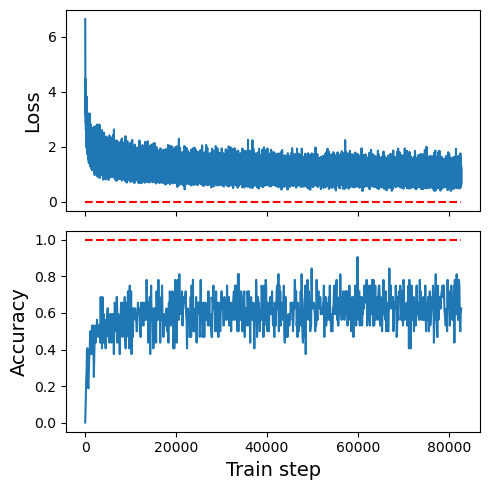

In [20]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [39]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).detach().numpy()
    

# Plotting results

In [42]:
from survey_ops.utils.geometry import angular_separation


## First, visualize healpix's gridding and actual ra, dec of observed fields

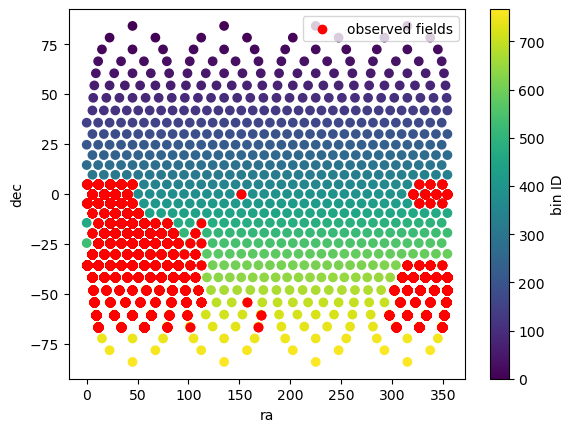

In [110]:
ordered_bin_radec = np.array([dataset.binid2radec[i] for i in range(len(dataset.binid2radec))])
c = plt.scatter(ordered_bin_radec[:, 0], ordered_bin_radec[:, 1], c=np.arange(len(ordered_bin_radec)))
cbar = plt.colorbar(c)
cbar.set_label(label='bin ID')

obs_bin_radec = np.array([dataset.binid2radec[bin_idx] for bin_idx in dataset.actions.detach().numpy()])
plt.scatter(obs_bin_radec[:, 0], obs_bin_radec[:, 1], color='red', label='observed fields')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()



In [111]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

In [116]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# Given the action (bin) chosen in the original schedule and in the policy's schedule
# obtain the angular separation between the two bins for all actions
target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

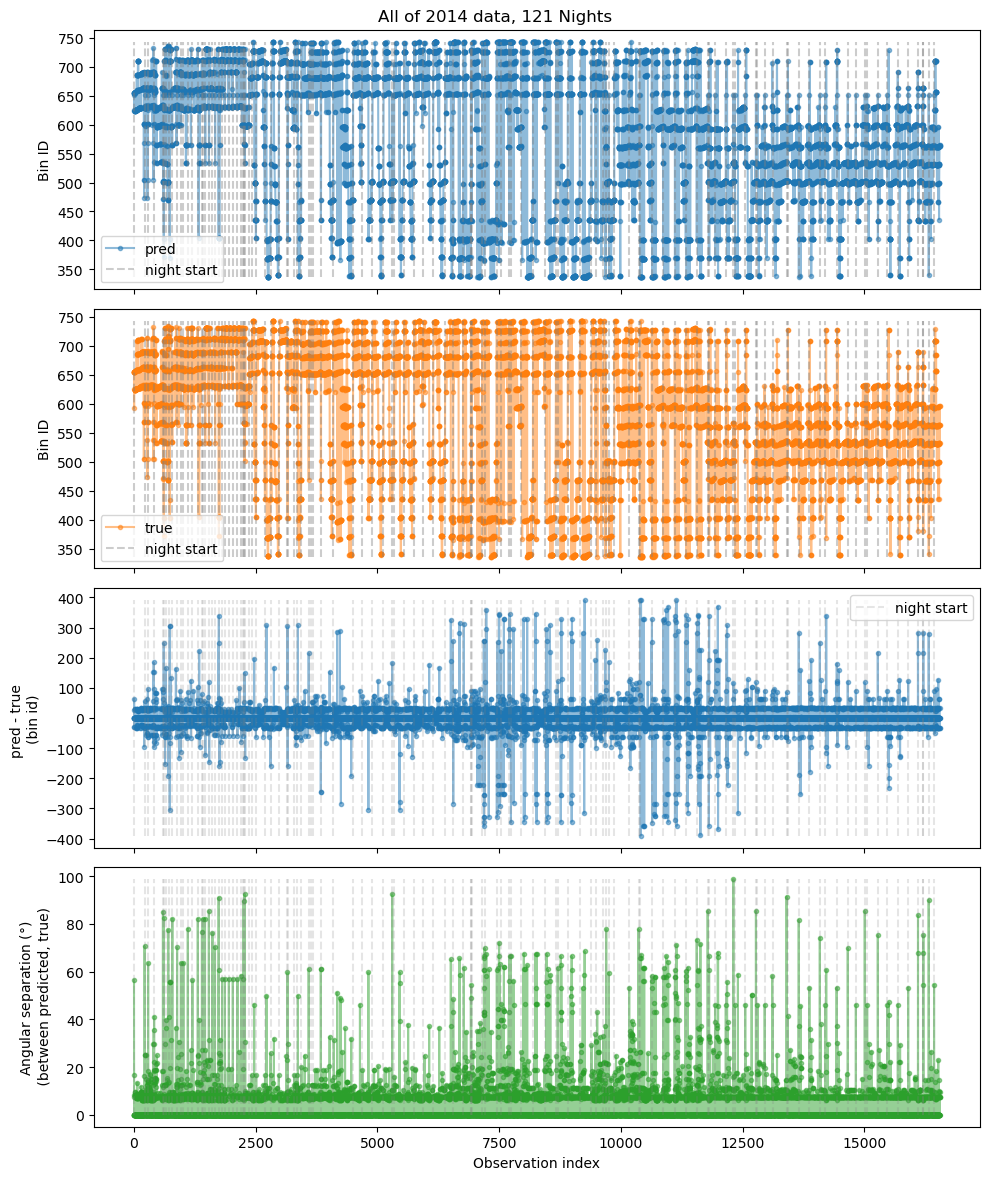

In [134]:
fig, axs = plt.subplots(4, figsize=(10,12), sharex=True)
axs[0].plot(eval_sequence, marker='o', label='pred', alpha=.5, markersize=3)
axs[0].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence), ymax=np.max(eval_sequence), linestyle='--', color='grey', label='night start', alpha=.4)
axs[0].set_ylabel('Bin ID')
axs[0].legend()

axs[1].plot(target_sequence, marker='o', label='true', color='C1', alpha=.5, markersize=3)
axs[1].vlines(first_obs_in_night_indices, ymin=np.min(target_sequence), ymax=np.max(target_sequence), linestyle='--', color='grey', label='night start', alpha=.4)
axs[1].set_ylabel('Bin ID')
axs[1].legend()

axs[2].plot(eval_sequence - target_sequence, marker='o', alpha=.5, markersize=3)
axs[2].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence - target_sequence), ymax=np.max(eval_sequence - target_sequence), linestyle='--', color='grey', label='night start', alpha=.2)
axs[2].legend()
axs[2].set_ylabel('pred - true \n(bin id)')

axs[3].plot(target_eval_angsep, marker='o', color='C2', alpha=.5, markersize=3)
axs[3].vlines(first_obs_in_night_indices, ymin=np.min(target_eval_angsep), ymax=np.max(target_eval_angsep), linestyle='--', color='grey', label='night start', alpha=.2)
axs[3].set_xlabel('Observation index')
axs[3].set_ylabel(r'Angular separation $(\degree)$' '\n (between predicted, true)')

fig.tight_layout()
fig.suptitle(f'All of 2014 data, {dataset.n_nights} Nights')
fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')